In [372]:
%load_ext autoreload
%autoreload 2

from src.sampling.main import stratified_spatial_kfold_dual

import torch
from torch_geometric.data import Data
from src.raingauge.utils import (
    get_station_coordinate_mappings,
    load_weather_station_dataset,
)
import pandas as pd
import numpy as np
import tqdm
import random
import matplotlib.pyplot as plt
import time
from scipy.stats import pearsonr
from src.radar.utils import load_radar_dataset
from src.visualization.radar import (
    visualize_one_radar_image,
)
import matplotlib as mpl
from models.gnn import GNNInductive
from datetime import datetime
from src.performance_logger import PerformanceLogger
import os
from src.visualization.inductive_graphs import visualize_splitted_graphs
from src.utils import (
    build_train_and_full_graph_homogeneous,
    add_homogeneous_weather_station_data,
    add_homogeneous_mask_to_data,
    generate_homogeneous_edges,
    add_homogeneous_edge_attributes_to_data,
    prepare_homogeneous_inductive_dataset,
    debug_dataloader,
)
import networkx as nx
from matplotlib.patches import Patch
import torch.nn.functional as F

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [373]:
# NOTE: Geographic extent of Singapore in longitude and latitude
bounds_singapore = {"left": 103.6, "right": 104.1, "top": 1.5, "bottom": 1.188}
bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20]
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend="both")

experiment_name = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_new"
os.makedirs(f"experiments/{experiment_name}", exist_ok=True)
perf = PerformanceLogger(f"experiments/{experiment_name}/training_log.jsonl")

# Preprocess Data

In [374]:
data = Data()
data1 = Data()
data2 = Data()
data3 = Data()
data4 = Data()
dtype = torch.float32


# Preprocess station data.
Some stations only contain rainfall information but some stations contain both rainfall and other information.
We will split these stations into weather station and general stations 

Additional info: 
  Windspeed
  Wind Direction
  Temperature
  Relative Humidity

In [375]:
weather_station_data = load_weather_station_dataset("weather_station_data.csv")
weather_station_locations = get_station_coordinate_mappings()
print(len(weather_station_locations.keys()))
print(len(set(weather_station_data["gid"].values)))
cols = list(weather_station_data.columns)
cols.remove("time_sgt")
cols.remove("gid")

weather_station_df_pivot = (
    pd.pivot(data=weather_station_data, index="time_sgt", columns="gid", values=cols)
    .resample("15min")
    .first()
)
weather_station_df_pivot["rain_rate"] = weather_station_df_pivot["rain_rate"] * 12
weather_station_df_counts = weather_station_df_pivot.count().reset_index()

weather_station_info = pd.pivot(
    data=weather_station_df_counts, index="gid", columns="level_0"
)

pd.set_option("display.max_rows", None)

rainfall_station = [
    row[0] for row in weather_station_info.iterrows() if 0 in row[1].value_counts()
]
general_station = [s for s in weather_station_locations if s not in rainfall_station]

print(rainfall_station)
print(general_station)
count = 0
for row in weather_station_df_pivot["rain_rate"].iterrows():
    if np.nansum(row[1].to_numpy()) != 0:
        count += 1
print(f"Number of timesteps that contain rain: {count}")
print(f"Total_timesteps = {weather_station_df_pivot.shape[0]}")

# After loading weather_station_df_pivot
print("--- Station Data Stats ---")
print(weather_station_df_pivot.describe())


64
63
['S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
['S109', 'S50', 'S107', 'S108', 'S44', 'S106', 'S111', 'S102', 'S60', 'S104', 'S43', 'S115', 'S121', 'S117', 'S116', 'S06']
Number of timesteps that contain rain: 1723
Total_timesteps = 8736
--- Station Data Stats ---
        rain_rate                                                     \
gid           S06          S07          S08        S102         S104   
count  4632.00000  7200.000000  8730.000000  707.000000  7210.000000   
mean      0.17513     0.565333     0.495395    0.020368     0.417420   
std       2.48162     4.595490     4.489146    0.337351     3.695896   
min       0.00000     0.000000     0.000000    0.0

In [376]:
general_station_data = {}
rainfall_station_data = {}

# TODO: Temporal Data Leakage - Filling missing values in the training set using all data including validation or test set is wrong.
# Extract and interpolate station data
for station in weather_station_df_pivot.columns.get_level_values(1).unique():
    station_cols = (
        weather_station_df_pivot.xs(station, level=1, axis=1)
        .interpolate(method="linear")
        .fillna(method="ffill")
        .fillna(method="bfill")
    )
    if station in general_station:
        general_station_data[station] = station_cols.values
    else:
        rainfall_station_data[station] = station_cols.values[:, 0:1]

general_station_temp = [stn for stn in general_station if stn != "S108"]
general_station = general_station_temp

# Prepare features in the correct order
general_station_features = []
rainfall_station_features = []
general_station_ids = []
rainfall_station_ids = []

for station in general_station:
    station_feat = general_station_data[station]
    general_station_features.append(station_feat)
    general_station_ids.append(station)

for station in rainfall_station:
    station_feat = rainfall_station_data[station]
    rainfall_station_features.append(station_feat)
    rainfall_station_ids.append(station)


/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_21786/319407748.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_station_df_pivot.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_21786/319407748.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_station_df_pivot.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_21786/319407748.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_station_df_pivot.xs(station, level=1, axis=1)
/var/folders/fd/qgmtjps95bzf3n9sz761k63h0000gn/T/ipykernel_21786/319407748.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use 

# Add Station Features to HeteroData Class

In [377]:
# Add station features to HeteroData

include_metastation_info = False
data = add_homogeneous_weather_station_data(
    data,
    general_station_features,
    rainfall_station_features,
    general_station_ids,
    rainfall_station_ids,
    dtype=dtype,
)
data1 = add_homogeneous_weather_station_data(
    data1,
    general_station_features,
    rainfall_station_features,
    general_station_ids,
    rainfall_station_ids,
    dtype=dtype,
)
data2 = add_homogeneous_weather_station_data(
    data2,
    general_station_features,
    rainfall_station_features,
    general_station_ids,
    rainfall_station_ids,
    dtype=dtype,
)
data3 = add_homogeneous_weather_station_data(
    data3,
    general_station_features,
    rainfall_station_features,
    general_station_ids,
    rainfall_station_ids,
    dtype=dtype,
)
data4 = add_homogeneous_weather_station_data(
    data4,
    general_station_features,
    rainfall_station_features,
    general_station_ids,
    rainfall_station_ids,
    dtype=dtype,
)


Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63])

=== Station Features Added ===
Station features shape: torch.Size([8736, 63, 1])
Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63])

=== Station Features Added ===
Station features shape: torch.Size([8736, 63, 1])
Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63])

=== Station Features Added ===
Station features shape: torch.Size([8736, 63, 1])
Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63])

=== Station Features Added ===
Station features shape: torch.Size([8736, 63, 1])
Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63])

=== Station Features Added ===
Station features shape: torch.Size([8736, 63, 1])


# Stratified K Fold Spatial Sampling

SPATIAL K-FOLD STRATIFIED SAMPLING (Fixed)
Total stations: 64
Clusters: 8
Folds: 5
Random seed: 123
--------------------------------------------------------------------------------
Cluster 0: 13 stations → 5 test assignments, 8 always-train
Cluster 1: 8 stations → 5 test assignments, 3 always-train
Cluster 2: 8 stations → 5 test assignments, 3 always-train
Cluster 3: 12 stations → 5 test assignments, 7 always-train
Cluster 4: 8 stations → 5 test assignments, 3 always-train
Cluster 5: 6 stations → 5 test assignments, 1 always-train
Cluster 6: 7 stations → 5 test assignments, 2 always-train
Cluster 7: 2 stations → 2 test assignments, 0 always-train

Creating Fold 0/5
Test stations: 8 (should be ~8)
Train pool: 56
Fold 1 summary:
  Statistical train: 56 (87.5%)
  Test: 8 (12.5%)
  ML train: 47 (73.4%)
  ML validation: 9 (14.1%)

Visualization saved as fold_1_sampling_results.png


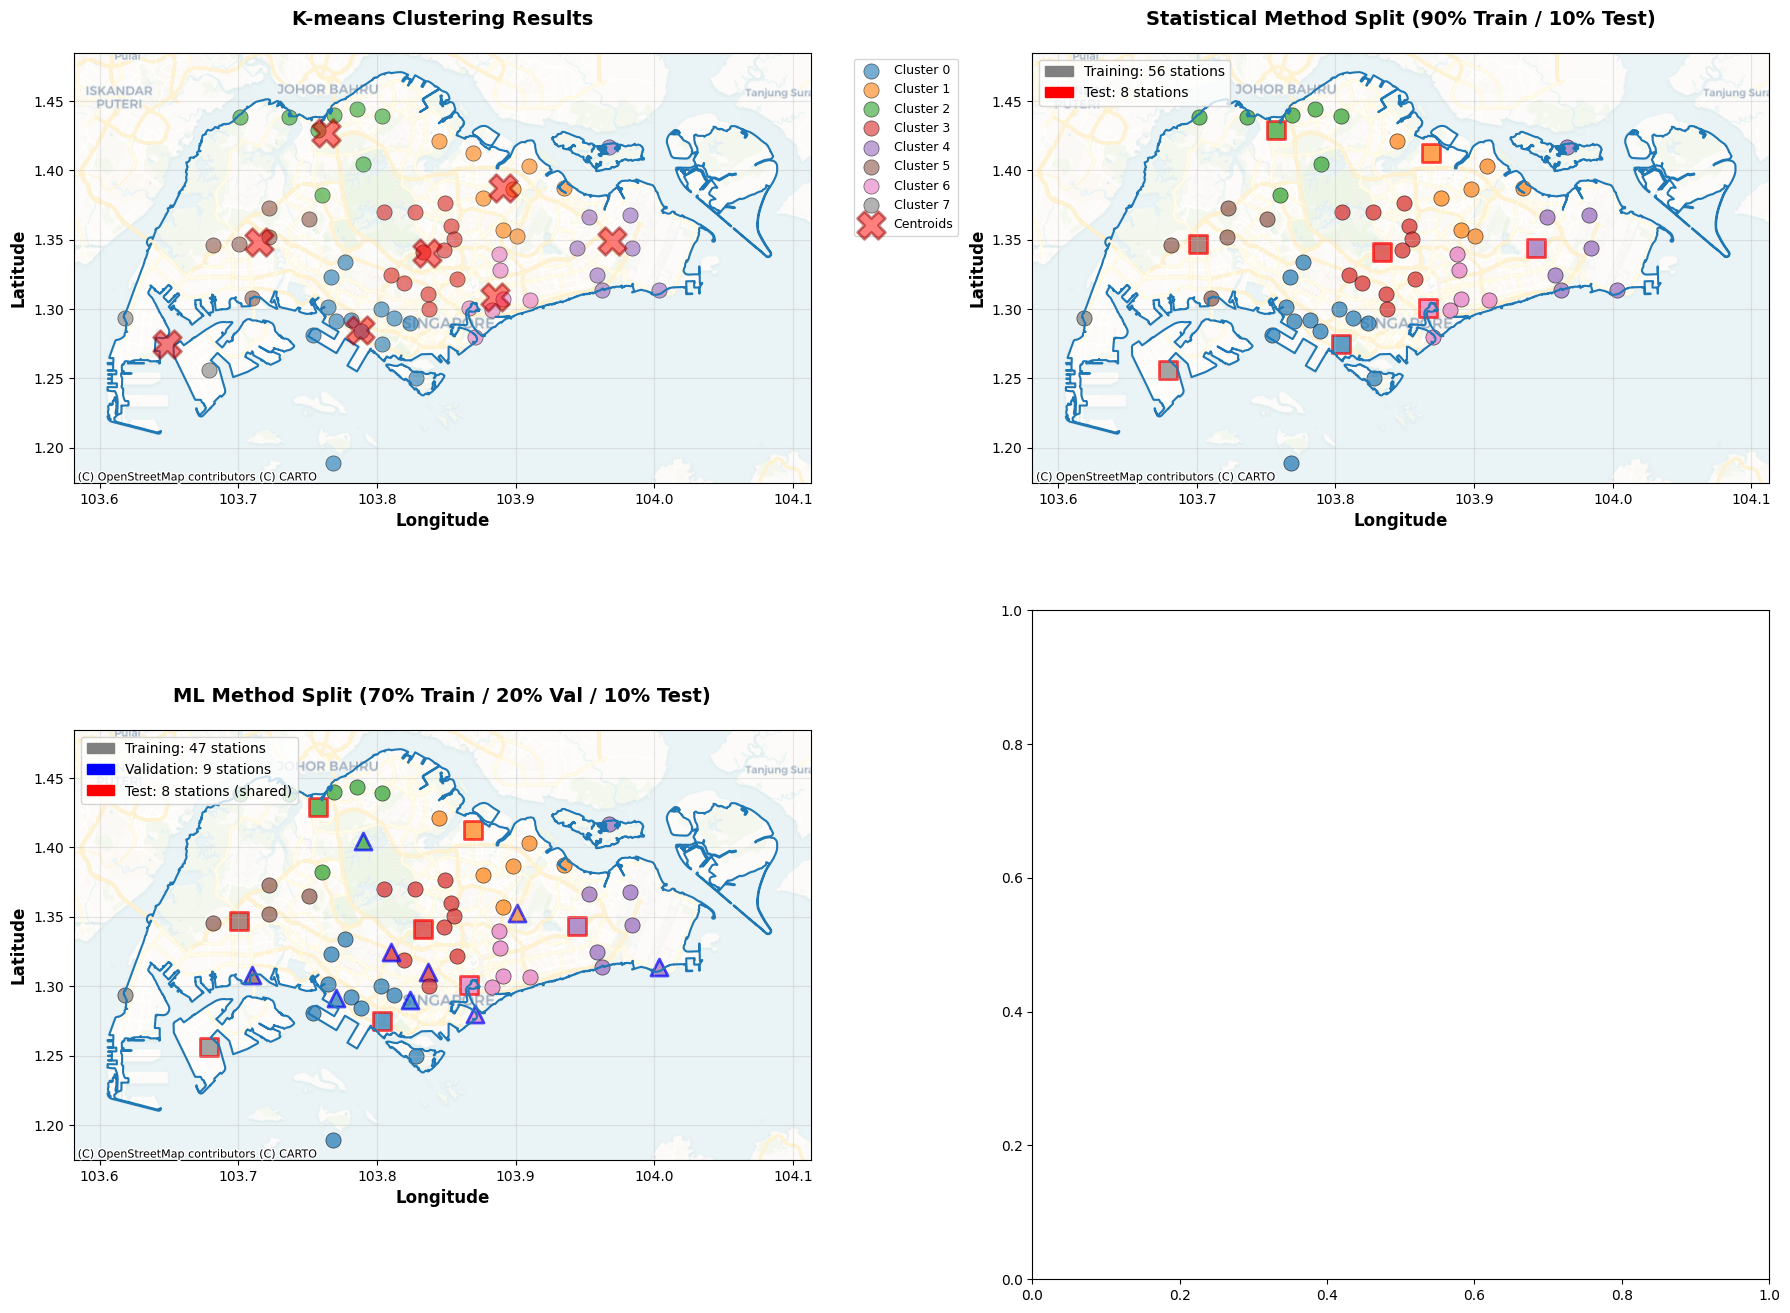


Creating Fold 1/5
Test stations: 8 (should be ~8)
Train pool: 56
Fold 2 summary:
  Statistical train: 56 (87.5%)
  Test: 8 (12.5%)
  ML train: 47 (73.4%)
  ML validation: 9 (14.1%)

Visualization saved as fold_2_sampling_results.png


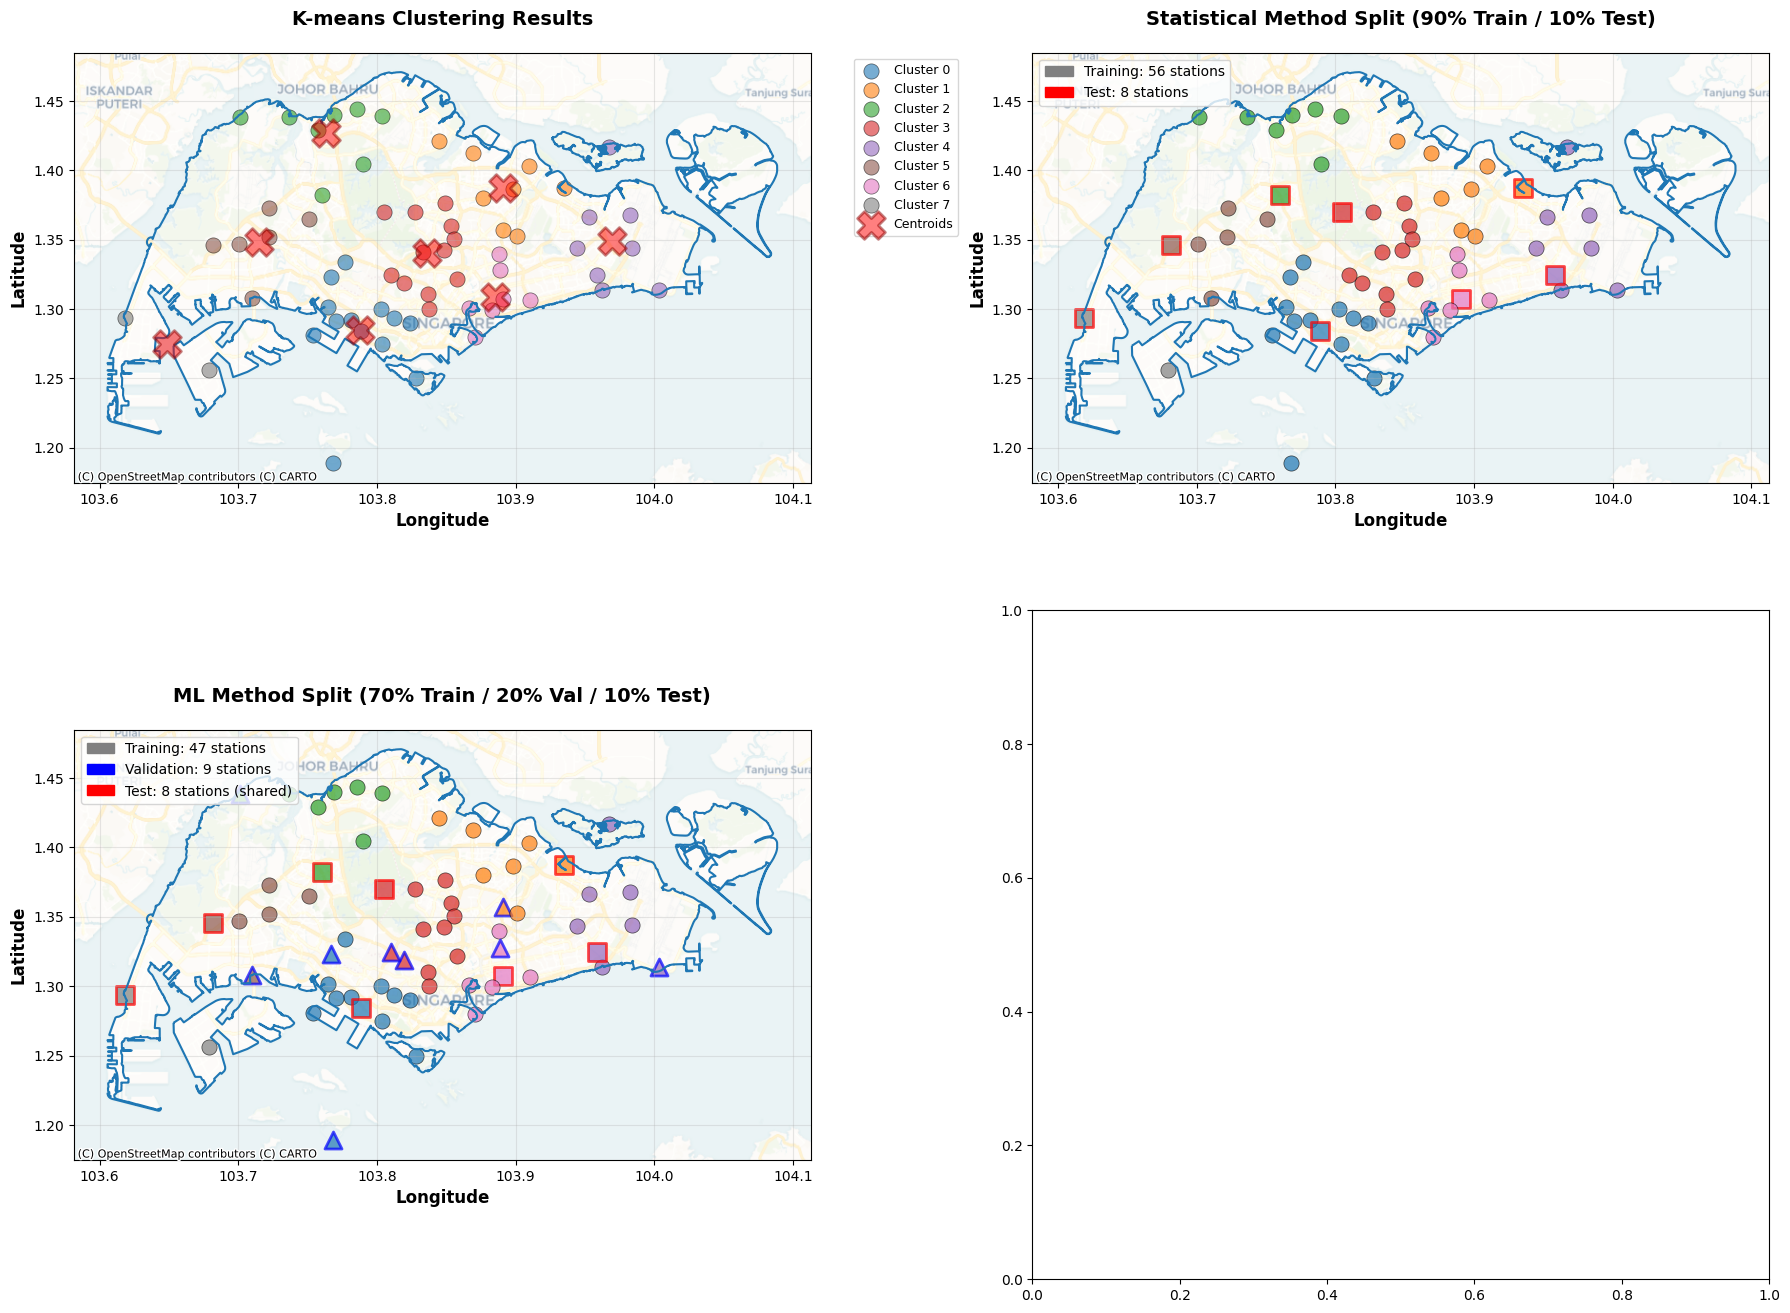


Creating Fold 2/5
Test stations: 7 (should be ~8)
Train pool: 57
Fold 3 summary:
  Statistical train: 57 (89.1%)
  Test: 7 (10.9%)
  ML train: 47 (73.4%)
  ML validation: 10 (15.6%)

Visualization saved as fold_3_sampling_results.png


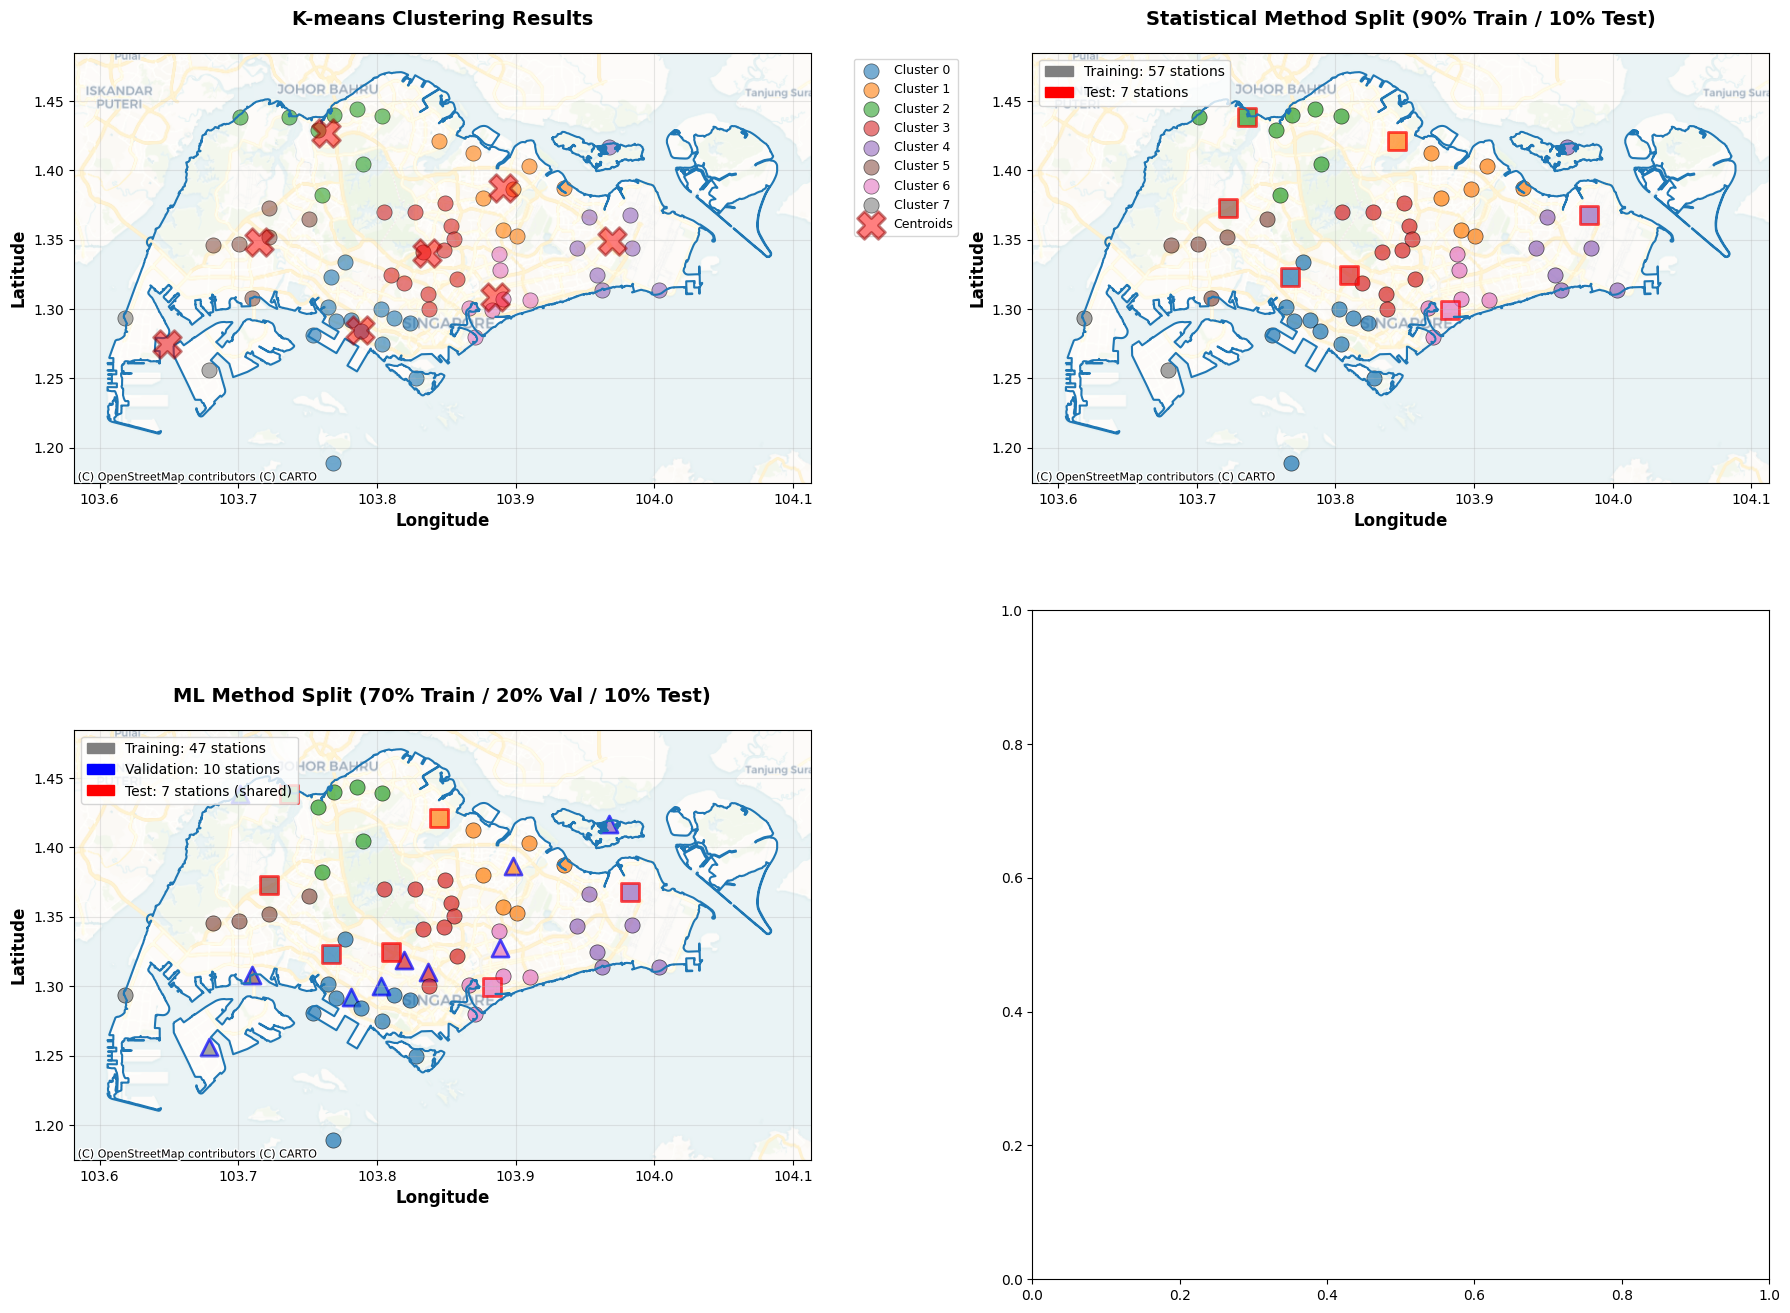


Creating Fold 3/5
Test stations: 7 (should be ~8)
Train pool: 57
Fold 4 summary:
  Statistical train: 57 (89.1%)
  Test: 7 (10.9%)
  ML train: 47 (73.4%)
  ML validation: 10 (15.6%)

Visualization saved as fold_4_sampling_results.png


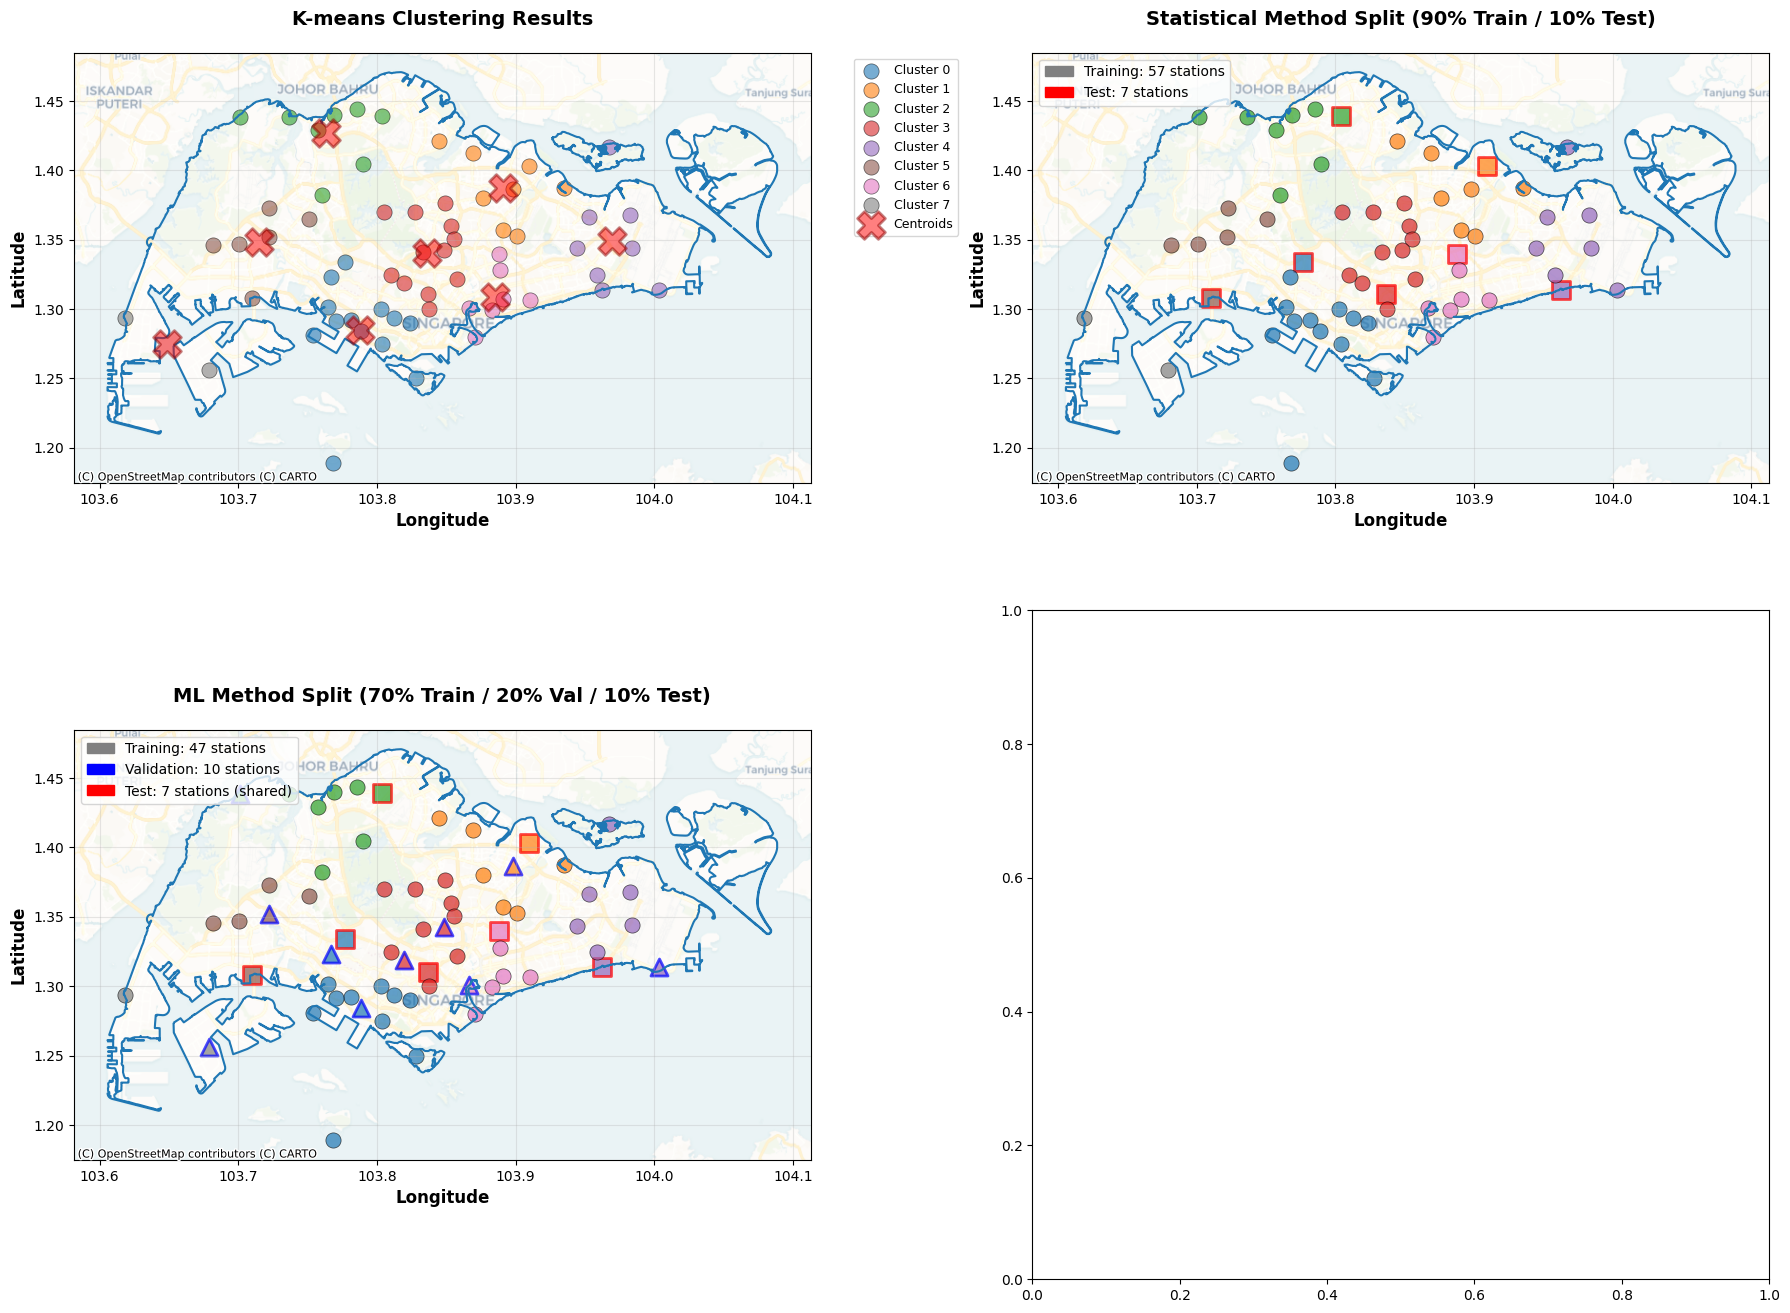


Creating Fold 4/5
Test stations: 7 (should be ~8)
Train pool: 57
Fold 5 summary:
  Statistical train: 57 (89.1%)
  Test: 7 (10.9%)
  ML train: 47 (73.4%)
  ML validation: 10 (15.6%)

Visualization saved as fold_5_sampling_results.png


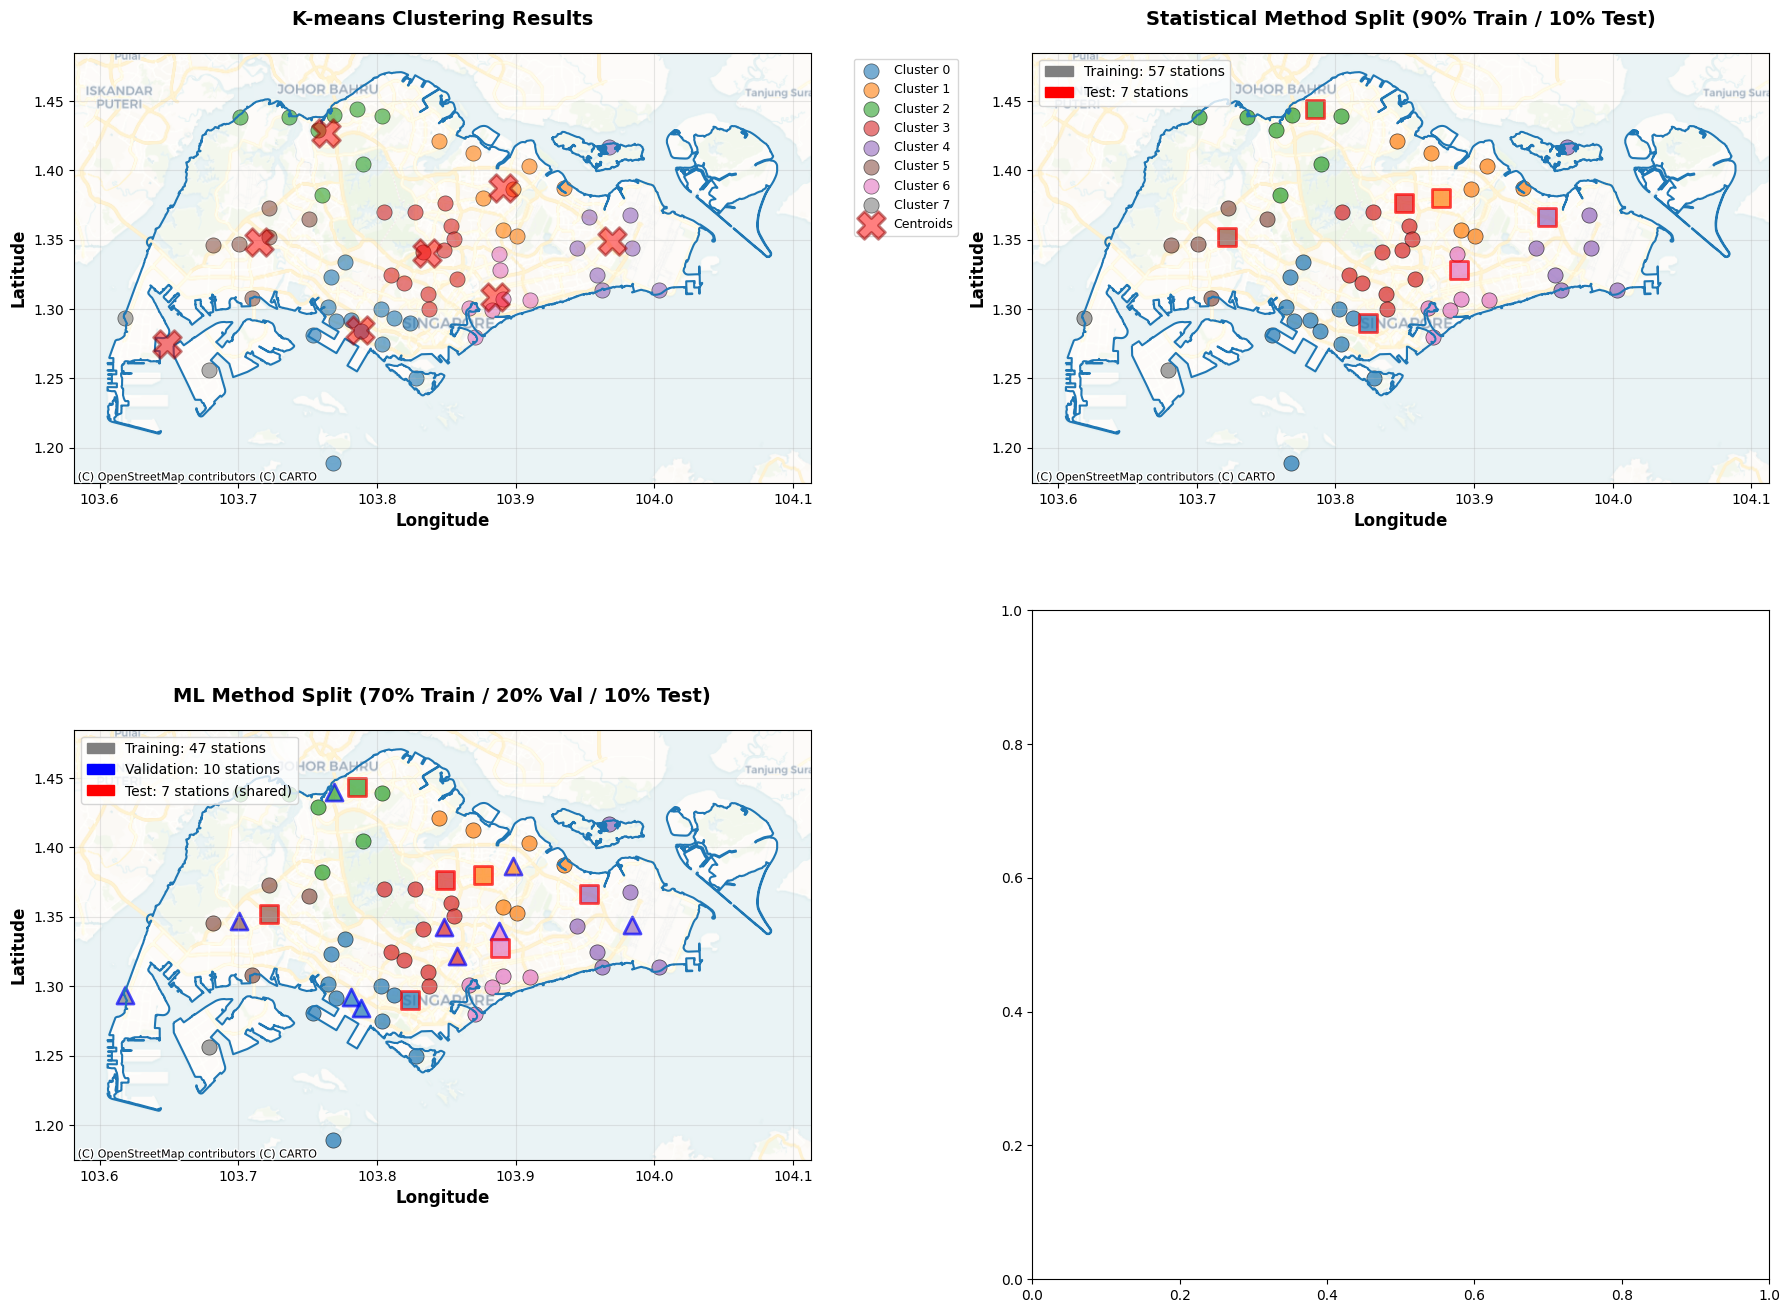


VERIFICATION
Total unique test stations across all folds: 37
Expected: 40
✓ K-Fold validation complete!
[{'fold_index': 0, 'statistical': {'train': array(['S92', 'S201', 'S50', 'S222', 'S203', 'S223', 'S230', 'S77',
       'S102', 'S71', 'S116', 'S60', 'S29', 'S209', 'S81', 'S219', 'S220',
       'S221', 'S06', 'S64', 'S66', 'S227', 'S104', 'S112', 'S40', 'S210',
       'S69', 'S213', 'S111', 'S109', 'S88', 'S123', 'S08', 'S90', 'S216',
       'S217', 'S79', 'S207', 'S24', 'S107', 'S94', 'S208', 'S224',
       'S106', 'S44', 'S121', 'S33', 'S229', 'S218', 'S78', 'S214', 'S43',
       'S215', 'S113', 'S108', 'S115'], dtype='<U4'), 'test': array(['S226', 'S900', 'S211', 'S07', 'S84', 'S228', 'S119', 'S117'],
      dtype='<U4')}, 'ml': {'train': array(['S92', 'S116', 'S60', 'S71', 'S102', 'S223', 'S230', 'S77', 'S50',
       'S201', 'S219', 'S29', 'S209', 'S81', 'S221', 'S220', 'S210',
       'S66', 'S112', 'S227', 'S64', 'S104', 'S217', 'S79', 'S08', 'S90',
       'S88', 'S123', 'S109',

In [378]:
split_info = stratified_spatial_kfold_dual(
    weather_station_locations, seed=123, plot=True
)
print(split_info)
stations = general_station + rainfall_station


In [379]:
data = add_homogeneous_mask_to_data(data, split_info[0], stations)
data1 = add_homogeneous_mask_to_data(data1, split_info[1], stations)
data2 = add_homogeneous_mask_to_data(data2, split_info[2], stations)
data3 = add_homogeneous_mask_to_data(data3, split_info[3], stations)
data4 = add_homogeneous_mask_to_data(data4, split_info[4], stations)

print("Data: \n", data)
print("Data1: \n", data1)
print("Data2: \n", data2)
print("Data3: \n", data3)
print("Data4: \n", data4)

Data: 
 Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63], train_mask=[63], val_mask=[63], test_mask=[63])
Data1: 
 Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63], train_mask=[63], val_mask=[63], test_mask=[63])
Data2: 
 Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63], train_mask=[63], val_mask=[63], test_mask=[63])
Data3: 
 Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63], train_mask=[63], val_mask=[63], test_mask=[63])
Data4: 
 Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63], train_mask=[63], val_mask=[63], test_mask=[63])


# Edge generation
We consider the location of the stations when performing our edge generation. 
General station locations and rainfall station locations will be considered the same and we will make a connection across the nodes if required. This will ensure that we can connect both the layers together in the graph.


Total stations for KNN: 63
['S109', 'S50', 'S107', 'S44', 'S106', 'S111', 'S102', 'S60', 'S104', 'S43', 'S115', 'S121', 'S117', 'S116', 'S06', 'S07', 'S08', 'S112', 'S113', 'S119', 'S123', 'S201', 'S203', 'S207', 'S208', 'S209', 'S210', 'S211', 'S213', 'S214', 'S215', 'S216', 'S217', 'S218', 'S219', 'S220', 'S221', 'S222', 'S223', 'S224', 'S226', 'S227', 'S228', 'S229', 'S230', 'S24', 'S29', 'S33', 'S40', 'S64', 'S66', 'S69', 'S71', 'S77', 'S78', 'S79', 'S81', 'S84', 'S88', 'S90', 'S900', 'S92', 'S94']
[[  1.3764  103.8492 ]
 [  1.3337  103.7768 ]
 [  1.3135  103.9625 ]
 [  1.34583 103.68166]
 [  1.4168  103.9673 ]
 [  1.31055 103.8365 ]
 [  1.189   103.768  ]
 [  1.25    103.8279 ]
 [  1.44387 103.78538]
 [  1.3399  103.8878 ]
 [  1.29377 103.61843]
 [  1.37288 103.72244]
 [  1.256   103.679  ]
 [  1.281   103.754  ]
 [  1.3524  103.9007 ]
 [  1.3415  103.8334 ]
 [  1.3701  103.8271 ]
 [  1.43854 103.70131]
 [  1.30648 103.9104 ]
 [  1.30105 103.8666 ]
 [  1.3214  103.8577 ]
 [  1.32

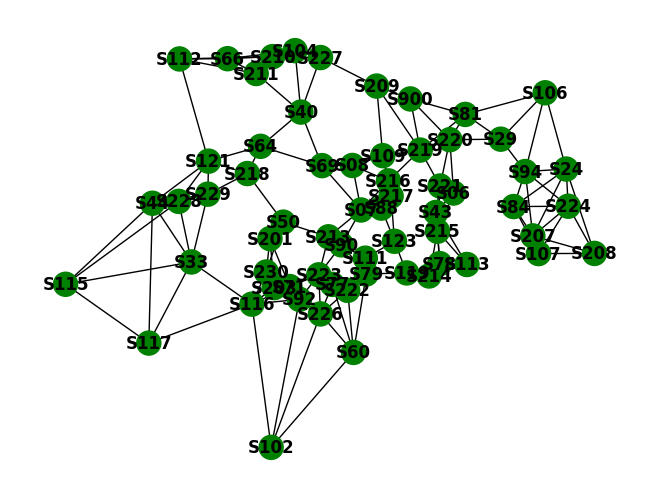

In [380]:
K = 4  # Number of neighbors per node
edges, edge_attributes = generate_homogeneous_edges(
    weather_station_locations,
    stations=stations,
    K=K,
)

data = add_homogeneous_edge_attributes_to_data(
    data, edges, edge_attributes, dtype=dtype
)
data1 = add_homogeneous_edge_attributes_to_data(
    data1, edges, edge_attributes, dtype=dtype
)
data2 = add_homogeneous_edge_attributes_to_data(
    data2, edges, edge_attributes, dtype=dtype
)
data3 = add_homogeneous_edge_attributes_to_data(
    data3, edges, edge_attributes, dtype=dtype
)
data4 = add_homogeneous_edge_attributes_to_data(
    data4, edges, edge_attributes, dtype=dtype
)

print(data)
print(data1)
print(data2)
print(data3)
print(data4)

In [381]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
# print_data_structure(data)
# print_data_structure(data1)
# print_data_structure(data2)
# print_data_structure(data3)
# print_data_structure(data4)


Train Data: Data(x=[8736, 47, 1], y=[8736, 47, 1], station_id=[63], train_mask=[47], val_mask=[47], test_mask=[47], edge_index=[2, 135], edge_attr=[1, 135], orig_id=[47])
Validation Data: Data(x=[8736, 55, 1], y=[8736, 55, 1], station_id=[63], train_mask=[55], val_mask=[55], test_mask=[55], edge_index=[2, 191], edge_attr=[1, 191], orig_id=[55])
Data Full: Data(x=[8736, 63, 1], y=[8736, 63, 1], station_id=[63], train_mask=[63], val_mask=[63], test_mask=[63], edge_index=[2, 252], edge_attr=[1, 252], orig_id=[63])
GRAPH STRUCTURE ANALYSIS

--- Full Graph ---
Total stations: 63
Train nodes: 47
Val nodes: 8
Test nodes: 8
Full graph edges: 158

--- Train Graph ---
Train graph nodes: 47
orig_id mapping exists: 47 mappings
Train graph local indices: 0 to 46
Train graph global indices: [0 1 2 3 4]... (first 5)
Train graph edges: 85

--- Validation Graph (train + val nodes) ---
Validation graph nodes: 55
orig_id mapping exists: 55 mappings
Validation graph edges: 118

GENERATING GEOGRAPHICAL POS

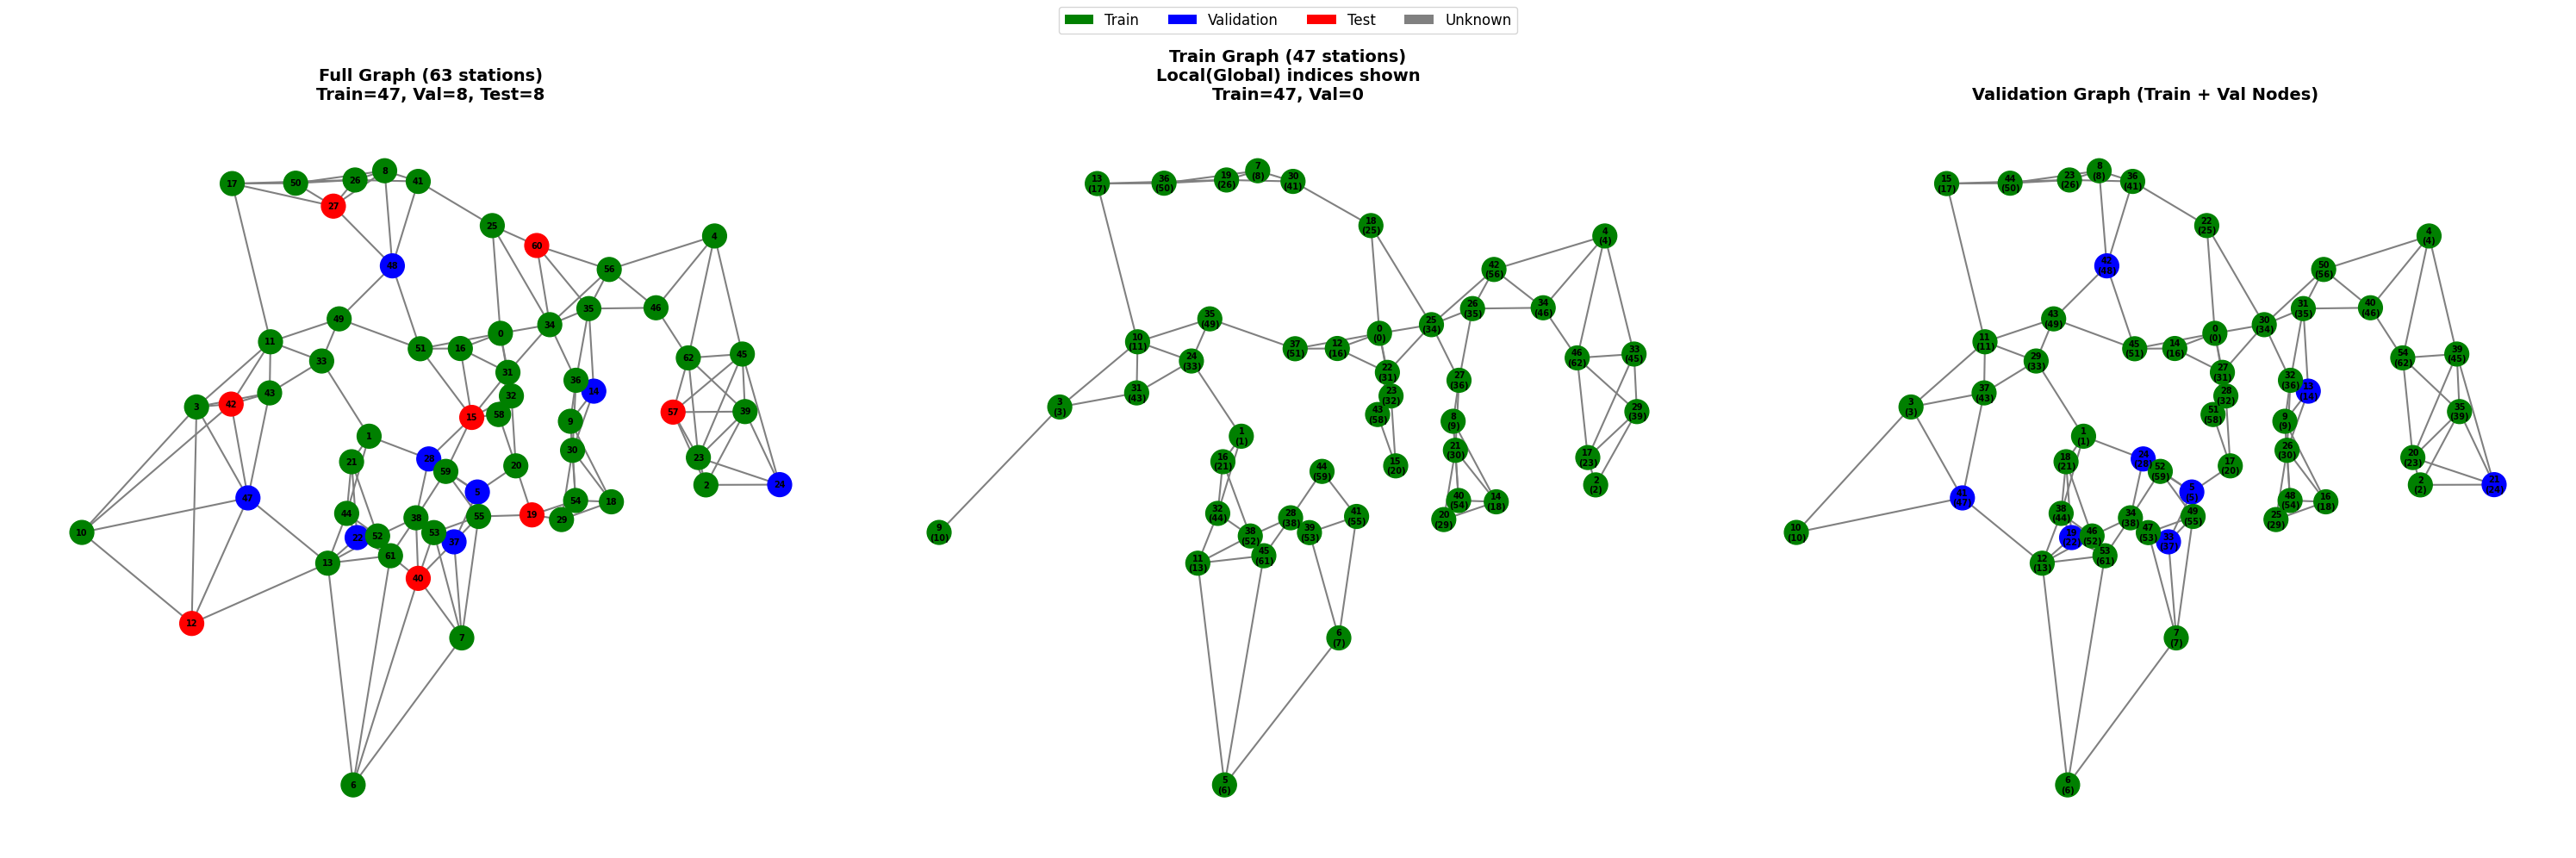


NODE MAPPING TABLE (First 10 nodes)
Local Idx    Global Idx   Station ID      Type in Train   Type in Full   
----------------------------------------------------------------------
0            0            S109            Train           Train          
1            1            S50             Train           Train          
2            2            S107            Train           Train          
3            3            S44             Train           Train          
4            4            S106            Train           Train          
5            6            S102            Train           Train          
6            7            S60             Train           Train          
7            8            S104            Train           Train          
8            9            S43             Train           Train          
9            10           S115            Train           Train          

SUMMARY

    ✅ Full Graph: 63 nodes, 158 edges
    - Uses GLOBAL indices (0 t

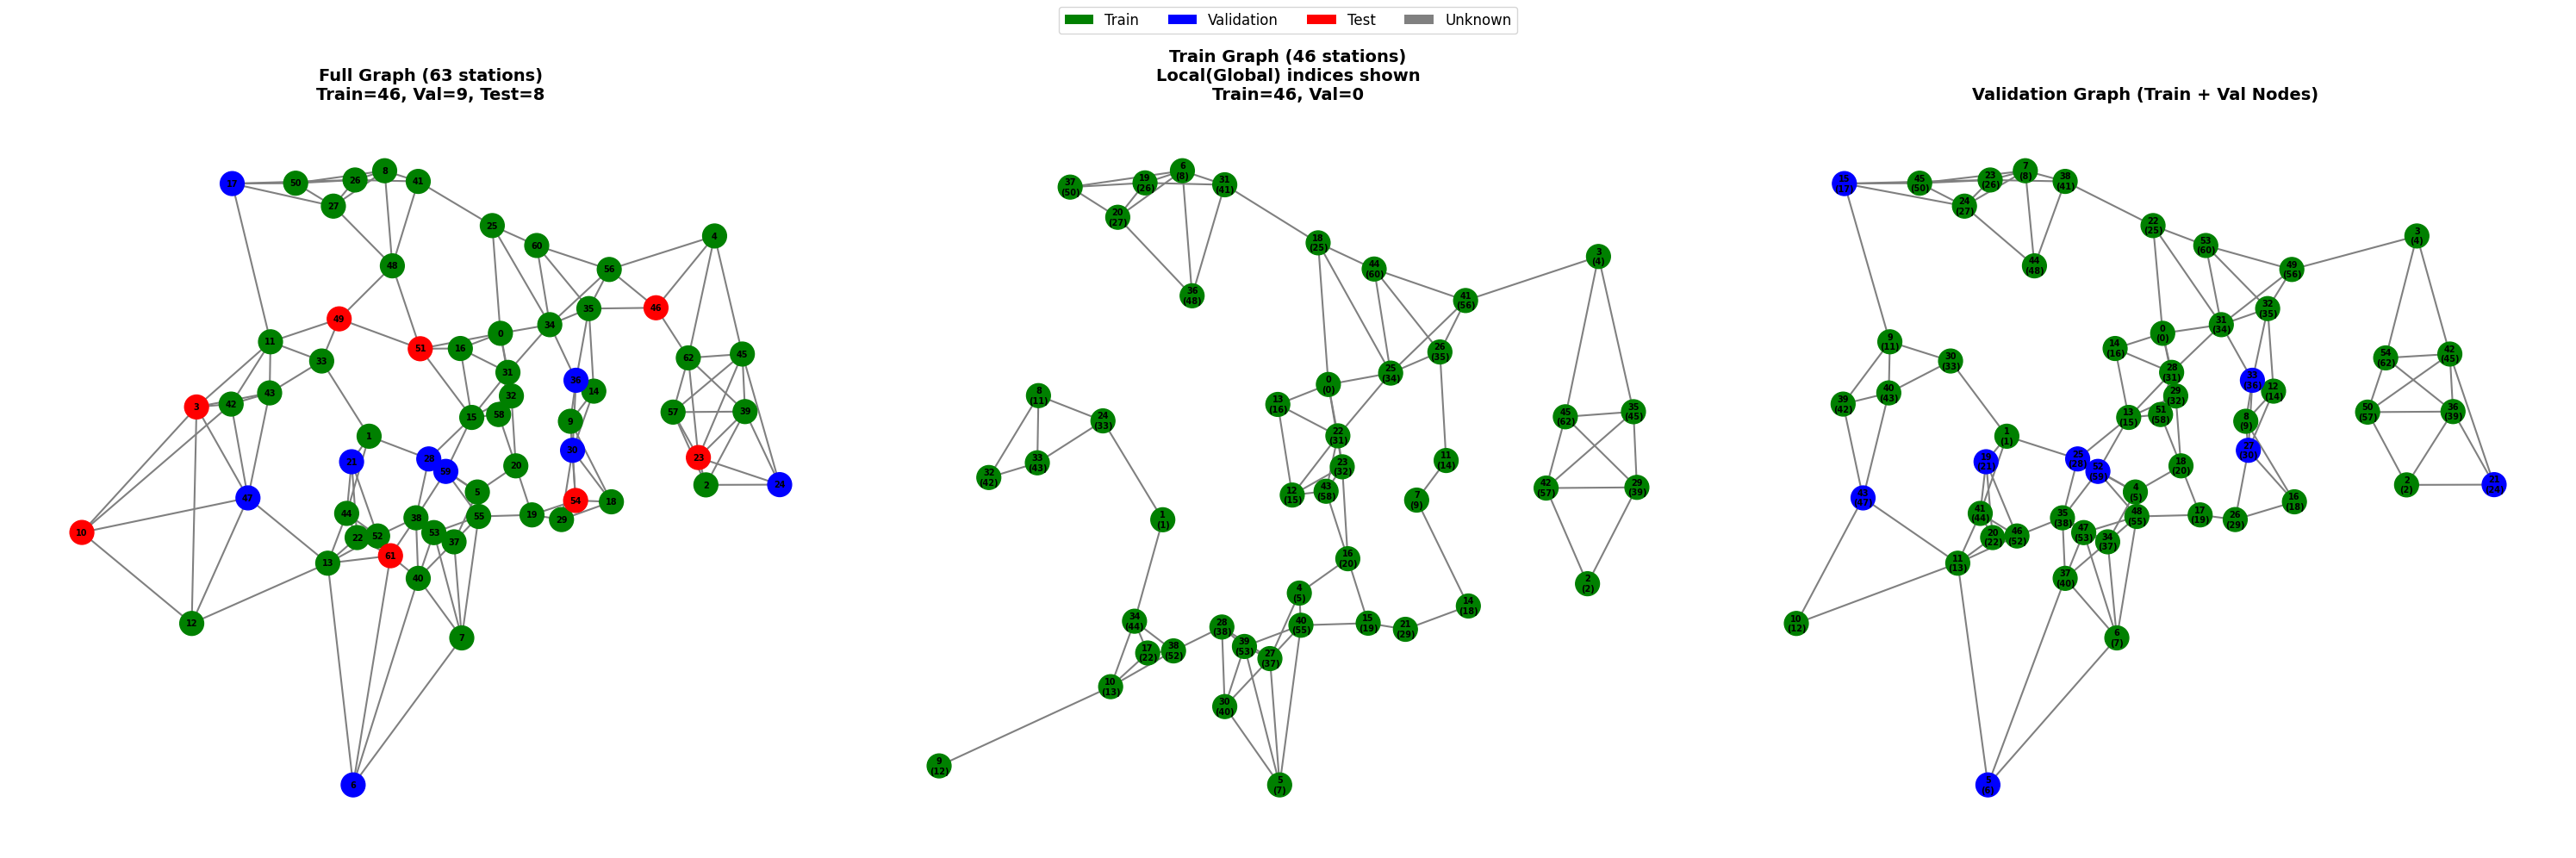


NODE MAPPING TABLE (First 10 nodes)
Local Idx    Global Idx   Station ID      Type in Train   Type in Full   
----------------------------------------------------------------------
0            0            S109            Train           Train          
1            1            S50             Train           Train          
2            2            S107            Train           Train          
3            4            S106            Train           Train          
4            5            S111            Train           Train          
5            7            S60             Train           Train          
6            8            S104            Train           Train          
7            9            S43             Train           Train          
8            11           S121            Train           Train          
9            12           S117            Train           Train          

SUMMARY

    ✅ Full Graph: 63 nodes, 158 edges
    - Uses GLOBAL indices (0 t

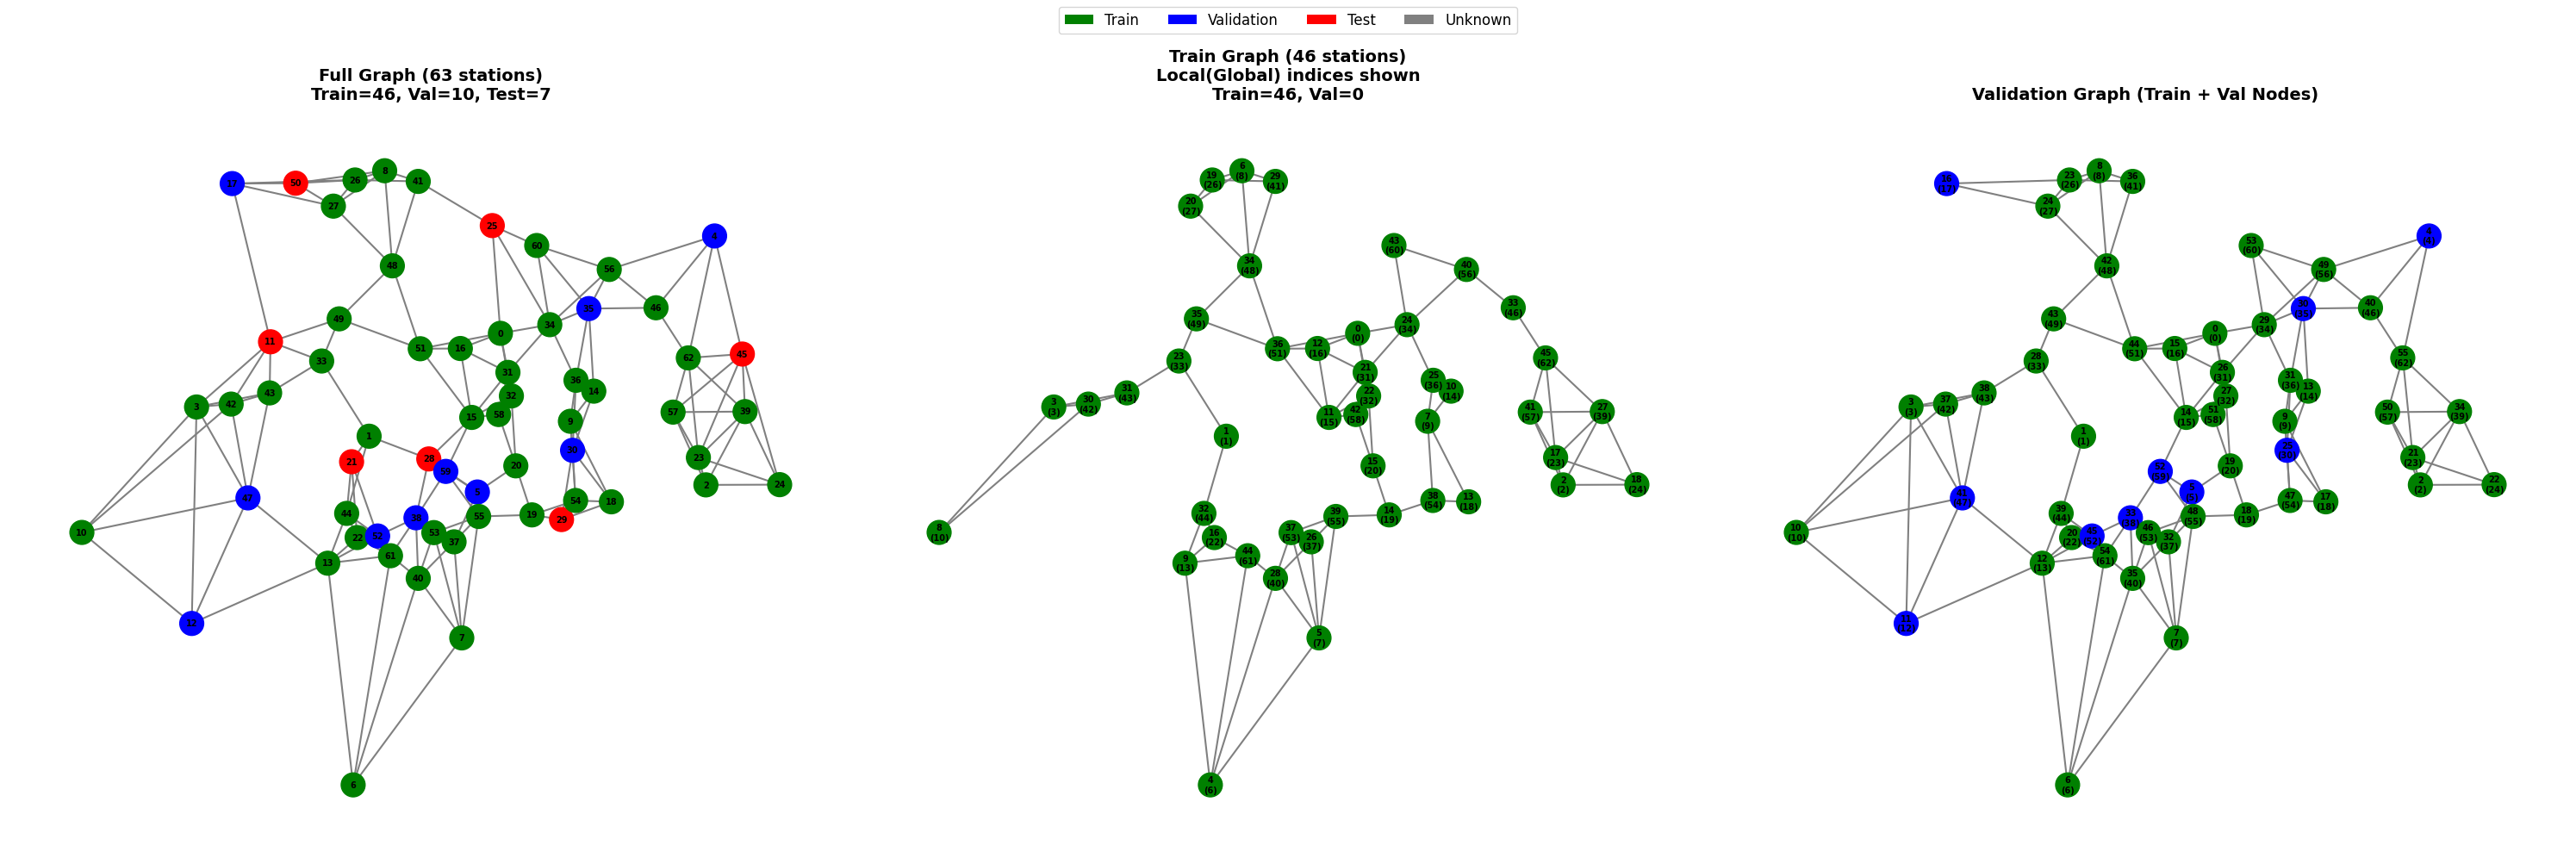


NODE MAPPING TABLE (First 10 nodes)
Local Idx    Global Idx   Station ID      Type in Train   Type in Full   
----------------------------------------------------------------------
0            0            S109            Train           Train          
1            1            S50             Train           Train          
2            2            S107            Train           Train          
3            3            S44             Train           Train          
4            6            S102            Train           Train          
5            7            S60             Train           Train          
6            8            S104            Train           Train          
7            9            S43             Train           Train          
8            10           S115            Train           Train          
9            13           S116            Train           Train          

SUMMARY

    ✅ Full Graph: 63 nodes, 158 edges
    - Uses GLOBAL indices (0 t

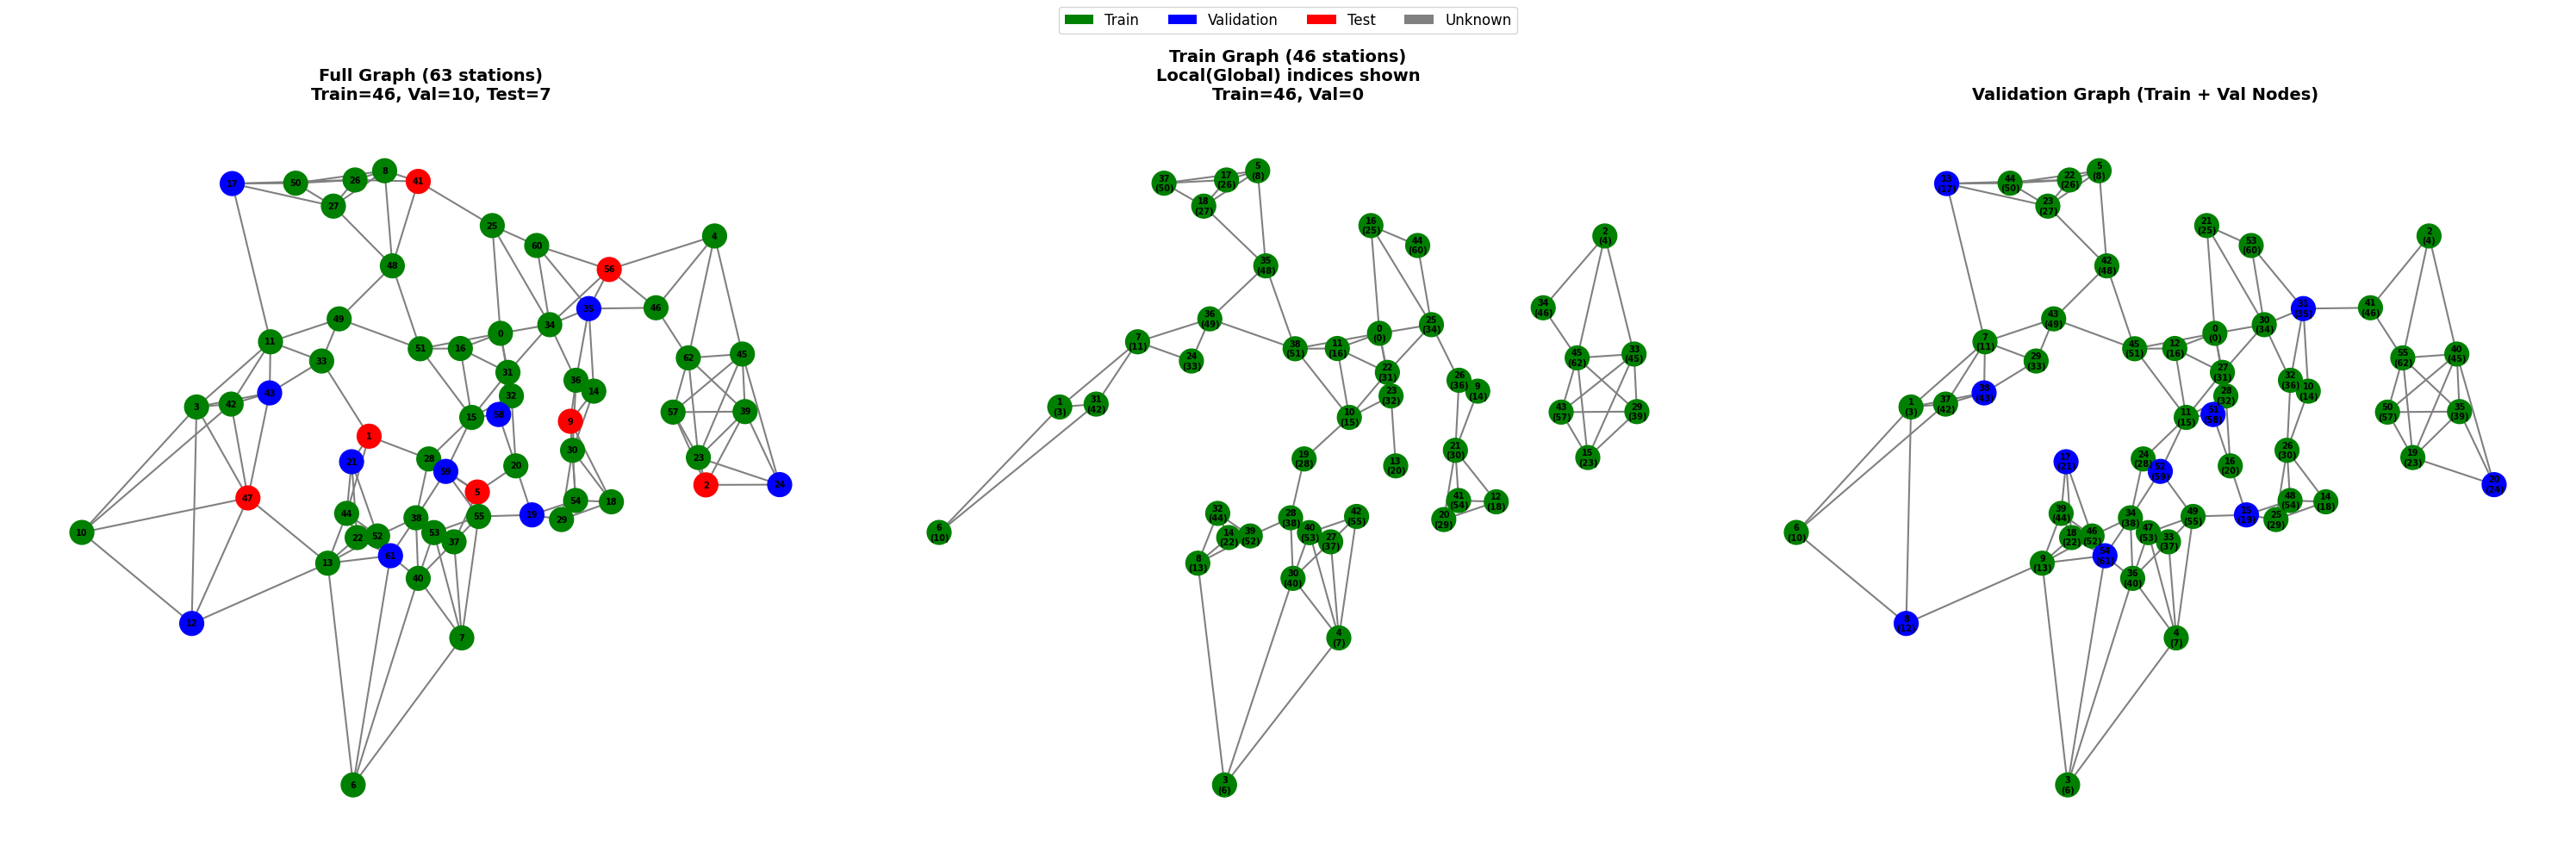


NODE MAPPING TABLE (First 10 nodes)
Local Idx    Global Idx   Station ID      Type in Train   Type in Full   
----------------------------------------------------------------------
0            0            S109            Train           Train          
1            3            S44             Train           Train          
2            4            S106            Train           Train          
3            6            S102            Train           Train          
4            7            S60             Train           Train          
5            8            S104            Train           Train          
6            10           S115            Train           Train          
7            11           S121            Train           Train          
8            13           S116            Train           Train          
9            14           S06             Train           Train          

SUMMARY

    ✅ Full Graph: 63 nodes, 158 edges
    - Uses GLOBAL indices (0 t

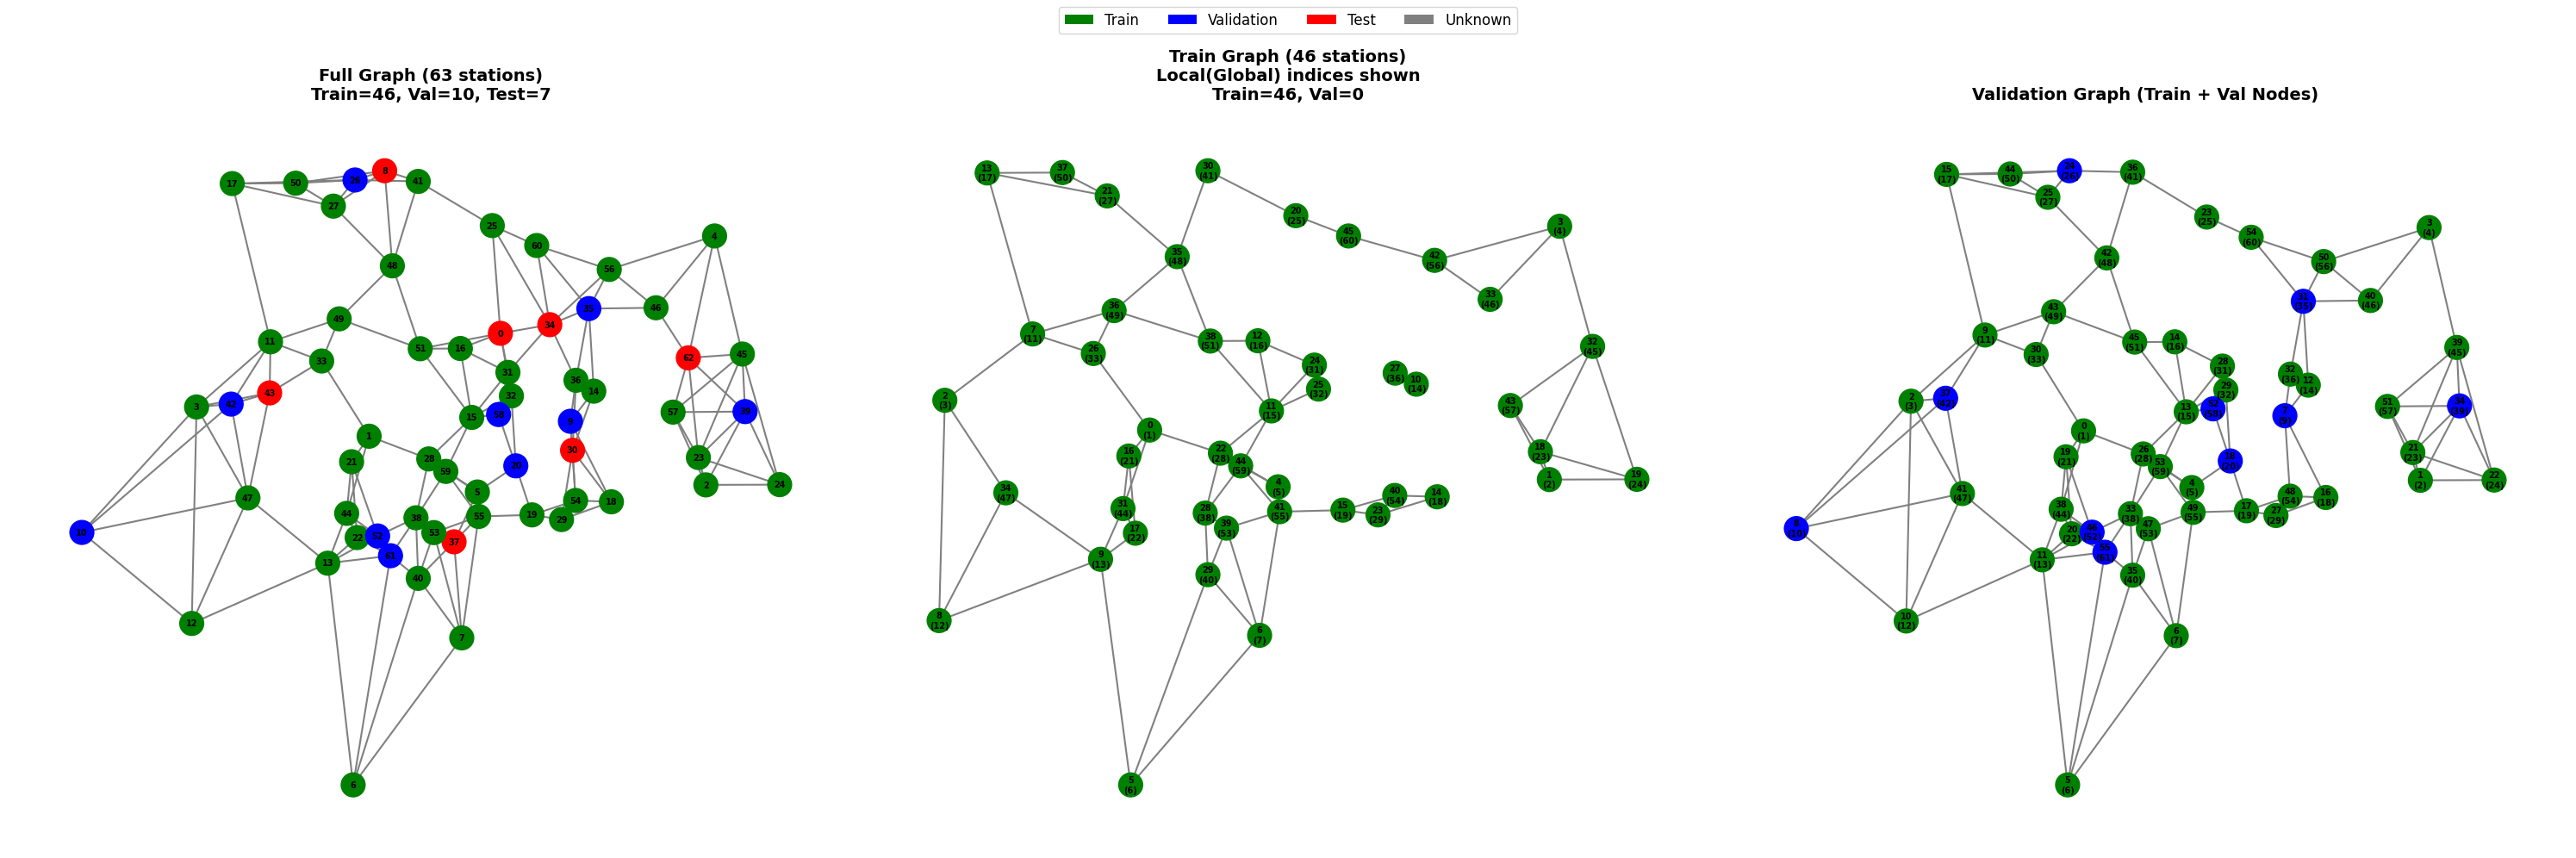


NODE MAPPING TABLE (First 10 nodes)
Local Idx    Global Idx   Station ID      Type in Train   Type in Full   
----------------------------------------------------------------------
0            1            S50             Train           Train          
1            2            S107            Train           Train          
2            3            S44             Train           Train          
3            4            S106            Train           Train          
4            5            S111            Train           Train          
5            6            S102            Train           Train          
6            7            S60             Train           Train          
7            11           S121            Train           Train          
8            12           S117            Train           Train          
9            13           S116            Train           Train          

SUMMARY

    ✅ Full Graph: 63 nodes, 158 edges
    - Uses GLOBAL indices (0 t

In [382]:
train_graphs = []
validation_graphs = []
full_graphs = []

for fold_idx in range(5):
    train_g, val_g, full_g = build_train_and_full_graph_homogeneous(
        data, split_info[fold_idx], stations
    )
    train_graphs.append(train_g)
    validation_graphs.append(val_g)
    full_graphs.append(full_g)

print(
    f"Train Data: {train_graphs[0]}\nValidation Data: {validation_graphs[0]}\nData Full: {full_graphs[0]}"
)

visualize_splitted_graphs(
    stations,
    weather_station_locations,
    train_graphs[0],
    validation_graphs[0],
    full_graphs[0],
    0,
    f"experiments/{experiment_name}",
)
visualize_splitted_graphs(
    stations,
    weather_station_locations,
    train_graphs[1],
    validation_graphs[1],
    full_graphs[1],
    1,
    f"experiments/{experiment_name}",
)
visualize_splitted_graphs(
    stations,
    weather_station_locations,
    train_graphs[2],
    validation_graphs[2],
    full_graphs[2],
    2,
    f"experiments/{experiment_name}",
)
visualize_splitted_graphs(
    stations,
    weather_station_locations,
    train_graphs[3],
    validation_graphs[3],
    full_graphs[3],
    3,
    f"experiments/{experiment_name}",
)
visualize_splitted_graphs(
    stations,
    weather_station_locations,
    train_graphs[4],
    validation_graphs[4],
    full_graphs[4],
    4,
    f"experiments/{experiment_name}",
)


# Creating the GNN

In [383]:
hidden_channels = 4
in_channels = 1
out_channels = 1
num_layers = 8

model = GNNInductive(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
)
model1 = GNNInductive(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
)
model2 = GNNInductive(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
)
model3 = GNNInductive(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
)
model4 = GNNInductive(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    num_layers=num_layers,
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device=device)
model1.to(device=device)
model2.to(device=device)
model3.to(device=device)
model4.to(device=device)

GNNInductive(
  (convs): ModuleList(
    (0): GraphConv(1, 4)
    (1-7): 7 x GraphConv(4, 4)
  )
  (lin_general): Linear(4, 1, bias=True)
)

In [384]:
def train_epoch(
    model,
    dataloader,
    optimizer,
    device,
    verbose=False,
    log_file="training_gnn_new_debug.log",
    random_noise_masking=False,
    scheduler=None,
):
    """
    Corrected training loop with gradient debugging.
    """
    model.train()
    epoch_losses = []
    charge_bar = tqdm.tqdm(dataloader, desc="training")

    for batch_idx, batch in enumerate(charge_bar):
        optimizer.zero_grad()

        # PyG Batch object - move to device
        batch = batch.to(device)

        # Extract from PyG Batch format
        x = batch.x  # [B*N, F]
        y = batch.y  # [B*N, Tgt]
        mask = batch.mask  # [N] - PROBLEM: single mask for one graph
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr if batch.edge_attr is not None else None
        num_graphs = batch.num_graphs

        # Properly replicate mask across batch
        # If mask is [N] and we have B graphs with N nodes each, replicate it
        if mask.shape[0] == x.shape[0] // num_graphs:
            # mask is per-graph, replicate for batch
            mask_expanded = mask.repeat(num_graphs)  # [B*N]
        else:
            mask_expanded = mask  # Already expanded

        assert mask_expanded.shape[0] == x.shape[0], (
            f"mask_expanded {mask_expanded.shape} != x {x.shape}"
        )

        # Check if any trainable nodes exist
        num_trainable = mask_expanded.sum().item()
        if num_trainable == 0:
            print(f"WARNING: No trainable nodes in batch {batch_idx}!")
            continue

        # Optionally add noise
        if random_noise_masking:
            noise = torch.randn_like(x) * 0.1
            x = x + noise

        # Mask features properly
        x_masked = x.clone()
        x_masked[~mask_expanded] = 0.0

        # Verify gradients can flow
        x_masked.requires_grad_(True)

        # Forward pass
        out = model(x_masked, edge_index, edge_attributes=edge_attr)

        # Compute loss ONLY on trainable nodes
        loss = F.mse_loss(out[mask_expanded], y[mask_expanded])

        if verbose or batch_idx == 0:
            print(f"loss: {loss.item()}, requires_grad: {loss.requires_grad}")

        # Check gradients before backward
        loss.backward()

        # Check if any gradients were computed
        total_grad_norm = 0.0
        num_params_with_grad = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                total_grad_norm += grad_norm**2
                num_params_with_grad += 1
                if verbose and grad_norm > 1e-6:
                    print(f"  {name}: grad_norm={grad_norm:.2e}")
            elif verbose or batch_idx == 0:
                print(f"  {name}: NO GRADIENT")

        total_grad_norm = np.sqrt(total_grad_norm)

        if num_params_with_grad == 0:
            print(f"ERROR: No gradients computed in batch {batch_idx}!")
            return None

        if total_grad_norm < 1e-8 and batch_idx % 20 == 0:
            print(
                f"WARNING: Very small gradient norm {total_grad_norm:.2e} in batch {batch_idx}"
            )

        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        epoch_losses.append(loss.item())
        charge_bar.set_postfix(
            {
                "loss": loss.item(),
                "grad_norm": total_grad_norm,
                "trainable": num_trainable,
            }
        )

    return float(np.mean(epoch_losses))

In [385]:
def validate(
    model, dataloader, device, verbose=False, log_file="validation_gnn_new_debug.log"
):
    """
    Validation loop for PyG batched graph data (inductive setting).

    Key aspects:
    1. Data comes as PyG Batch objects
    2. Features are [B*N, F], already batched and flattened
    3. Mask is [N] - single mask for one graph, replicated across batch
    4. Computes metrics ONLY on validation nodes (where mask=True)
    5. No gradients computed - eval mode
    """
    model.eval()
    epoch_losses = []
    all_preds = []
    all_targets = []

    charge_bar = tqdm.tqdm(dataloader, desc="validation")

    with torch.no_grad():
        for batch in charge_bar:
            # PyG Batch object - move to device
            batch = batch.to(device)

            # Extract from PyG Batch format
            x = batch.x  # [B*N, F] - already batched and flattened
            y = batch.y  # [B*N, Tgt] - already batched and flattened
            mask = batch.mask  # [N] - single mask for one graph
            edge_index = batch.edge_index  # [2, E*B] - offset edge indices
            edge_attr = batch.edge_attr if batch.edge_attr is not None else None

            assert mask.shape[0] == x.shape[0], (
                f"mask size {mask.shape[0]} != x size {x.shape[0]}"
            )

            # Forward pass
            out = model(x, edge_index, edge_attributes=edge_attr)  # [B*N, out_channels]

            # Compute loss ONLY on validation nodes
            val_mask = mask  # [B*N] boolean mask

            loss = F.mse_loss(out[val_mask], y[val_mask])
            epoch_losses.append(loss.item())

            # Store predictions and targets for metric computation
            all_preds.append(out[val_mask].detach().cpu())
            all_targets.append(y[val_mask].detach().cpu())

            charge_bar.set_postfix({"loss": loss.item()})

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds, dim=0)  # [Total_val_nodes, out_channels]
    all_targets = torch.cat(all_targets, dim=0)  # [Total_val_nodes, out_channels]

    # Compute metrics
    mean_loss = float(np.mean(epoch_losses))

    return mean_loss


In [386]:
# set seeds

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
perf.log_model_config(model.config)

batch_size = 16
train_loader, val_loader = prepare_homogeneous_inductive_dataset(
    train_graphs[0], validation_graphs[0], batch_size=batch_size, mode="train"
)
train_loader1, val_loader1 = prepare_homogeneous_inductive_dataset(
    train_graphs[1], validation_graphs[1], batch_size=batch_size, mode="train"
)
train_loader2, val_loader2 = prepare_homogeneous_inductive_dataset(
    train_graphs[2], validation_graphs[2], batch_size=batch_size, mode="train"
)
train_loader3, val_loader3 = prepare_homogeneous_inductive_dataset(
    train_graphs[3], validation_graphs[3], batch_size=batch_size, mode="train"
)
train_loader4, val_loader4 = prepare_homogeneous_inductive_dataset(
    train_graphs[4], validation_graphs[4], batch_size=batch_size, mode="train"
)

debug_dataloader(train_loader)
debug_dataloader(val_loader)


def train(model, train_loader, val_loader, fold, device="cpu"):
    # CHECK 1: Print initial weights
    first_param = next(model.parameters())
    print(f"Initial weight sample: {first_param.data.flatten()[:5]}")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    training_loss_arr = []
    validation_loss_arr = []
    early = 0
    mini = 1000
    stopping_condition = 5
    epochs = 0
    total_epochs = 10
    print(f"-----FOLD: {fold}-----")
    training_start = time.time()
    for i in range(total_epochs):
        print(f"-----EPOCH: {i + 1}-----")

        # CHECK 2: Print weight before training
        weight_before = first_param.data.clone()

        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            device,
            verbose=False,
            random_noise_masking=False,
        )

        # CHECK 3: Print weight after training
        weight_after = first_param.data
        weight_change = (weight_after - weight_before).abs().mean().item()
        print(f"Weight change: {weight_change:.20f}")

        validation_loss = validate(model, val_loader, device)
        training_loss_arr.append(train_loss)
        validation_loss_arr.append(validation_loss)
        perf.log_epoch(i, train_loss, validation_loss)
        if mini >= validation_loss:
            mini = validation_loss
            early = 0
        else:
            early += 1
        epochs += 1
        if early >= stopping_condition:
            print("Early stop loss")
            break

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {validation_loss:.4f}")

        # CHECK 4: Print gradient norms
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item() ** 2
        total_norm = total_norm**0.5
        print(f"Gradient norm: {total_norm:.6f}")

    training_end = time.time()
    total_time = training_end - training_start
    perf.finalise(total_time)

    print(f"Training took {total_time} seconds over {epochs} epochs")
    plt.plot(training_loss_arr, label="training_loss", color="blue")
    plt.plot(validation_loss_arr, label="validation_loss", color="red")
    plt.legend()
    plt.savefig(f"experiments/{experiment_name}/train_loss_plot_{fold}.png", dpi=300)
    plt.close()

    torch.save(
        model.state_dict(), f"experiments/{experiment_name}/weather_gnn_best_{fold}.pth"
    )
    print("✅ model weights saved to weather_gnn_best.pth")

    perf.log_model_parameters(model)
    return model


model = train(model, train_loader, val_loader, fold=0, device=device)
model1 = train(model1, train_loader1, val_loader1, fold=1, device=device)
model2 = train(model2, train_loader2, val_loader2, fold=2, device=device)
model3 = train(model3, train_loader3, val_loader3, fold=3, device=device)
model4 = train(model4, train_loader4, val_loader4, fold=4, device=device)



PREPARING TRAIN/VAL DATALOADERS (using train_graph)
Sample node features shape: torch.Size([47, 1])
Sample labels shape: torch.Size([47, 1])
Train mask shape: torch.Size([47])
Train mask sum (trainable nodes): 47
✅ Train loader: 546 batches
✅ Val loader: 546 batches

BATCH VERIFICATION
Batch content: DataBatch(x=[752, 1], edge_index=[2, 2160], edge_attr=[16, 135], y=[752, 1], mask=[752], train_mask=[752], station_id=[752], batch=[752], ptr=[17])
Batched x shape: torch.Size([752, 1])
Batched y shape: torch.Size([752, 1])
Mask shape: torch.Size([752])
Edge index shape: torch.Size([2, 2160])
Batch vector shape: torch.Size([752])
Num graphs in batch: 16

Nodes per graph: 47
Mask size per graph: 47
✅ CORRECT!

PREPARING TRAIN/VAL DATALOADERS (using train_graph)
Sample node features shape: torch.Size([46, 1])
Sample labels shape: torch.Size([46, 1])
Train mask shape: torch.Size([46])
Train mask sum (trainable nodes): 46
✅ Train loader: 546 batches
✅ Val loader: 546 batches

BATCH VERIFICATI

training:   0%|          | 0/546 [00:00<?, ?it/s, loss=4.74, grad_norm=3.1, trainable=752]    

loss: 114.83344268798828, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 474.22it/s, loss=2.89, grad_norm=17.2, trainable=752]   


Weight change: 0.04058817774057388306


validation: 100%|██████████| 546/546 [00:00<00:00, 797.15it/s, loss=0.266]


Train Loss: 12.9388
Validation Loss: 8.7789
Gradient norm: 17.215327
-----EPOCH: 2-----


training:   9%|▉         | 49/546 [00:00<00:01, 484.23it/s, loss=2.73, grad_norm=6.41, trainable=752]   

loss: 3.40055775642395, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 465.50it/s, loss=8.12, grad_norm=4.04, trainable=752]  


Weight change: 0.07071040570735931396


validation: 100%|██████████| 546/546 [00:00<00:00, 747.96it/s, loss=0.261]  


Train Loss: 11.6822
Validation Loss: 11.1675
Gradient norm: 4.041614
-----EPOCH: 3-----


training:   9%|▉         | 49/546 [00:00<00:01, 482.76it/s, loss=1.88, grad_norm=4.8, trainable=752] 

loss: 23.117856979370117, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 468.82it/s, loss=2.57, grad_norm=7.41, trainable=752]   


Weight change: 0.15577962994575500488


validation: 100%|██████████| 546/546 [00:00<00:00, 795.04it/s, loss=0.000499]


Train Loss: 8.3542
Validation Loss: 4.4020
Gradient norm: 7.409684
-----EPOCH: 4-----


training:   9%|▉         | 49/546 [00:00<00:01, 480.91it/s, loss=0.288, grad_norm=5.77, trainable=752]  

loss: 0.4386785328388214, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 426.86it/s, loss=0.0779, grad_norm=1.41, trainable=752] 


Weight change: 0.06183694303035736084


validation: 100%|██████████| 546/546 [00:00<00:00, 791.79it/s, loss=0.000585]


Train Loss: 4.4863
Validation Loss: 6.4469
Gradient norm: 1.405021
-----EPOCH: 5-----


training:   9%|▉         | 49/546 [00:00<00:01, 483.05it/s, loss=10.1, grad_norm=31.1, trainable=752] 

loss: 1.6843827962875366, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 487.34it/s, loss=3.43, grad_norm=46.6, trainable=752]   


Weight change: 0.02577869221568107605


validation: 100%|██████████| 546/546 [00:00<00:00, 788.08it/s, loss=0.000602]


Train Loss: 5.1330
Validation Loss: 3.6653
Gradient norm: 46.561935
-----EPOCH: 6-----


training:   9%|▊         | 47/546 [00:00<00:01, 468.88it/s, loss=96.8, grad_norm=364, trainable=752]    

loss: 0.10931503772735596, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 481.22it/s, loss=0.0819, grad_norm=0.209, trainable=752]


Weight change: 0.01280627772212028503


validation: 100%|██████████| 546/546 [00:00<00:00, 786.72it/s, loss=0.000117]


Train Loss: 4.7832
Validation Loss: 3.8536
Gradient norm: 0.208989
-----EPOCH: 7-----


training:   9%|▉         | 48/546 [00:00<00:01, 479.10it/s, loss=0.142, grad_norm=1.24, trainable=752] 

loss: 1.6832536458969116, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 485.57it/s, loss=0.0428, grad_norm=1.61, trainable=752] 


Weight change: 0.00406115874648094177


validation: 100%|██████████| 546/546 [00:00<00:00, 778.63it/s, loss=0.000232]


Train Loss: 4.1287
Validation Loss: 3.9540
Gradient norm: 1.607179
-----EPOCH: 8-----


training:   9%|▉         | 48/546 [00:00<00:01, 479.32it/s, loss=24.2, grad_norm=500, trainable=752]    

loss: 1.0860399007797241, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 482.22it/s, loss=0.119, grad_norm=2.96, trainable=752]  


Weight change: 0.00296083791181445122


validation: 100%|██████████| 546/546 [00:00<00:00, 783.64it/s, loss=0.00103]


Train Loss: 3.8864
Validation Loss: 5.2249
Gradient norm: 2.964890
-----EPOCH: 9-----


training:   9%|▉         | 48/546 [00:00<00:01, 475.42it/s, loss=2.78, grad_norm=55.1, trainable=752]   

loss: 16.090476989746094, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 481.46it/s, loss=0.812, grad_norm=19.3, trainable=752]  


Weight change: 0.00478707905858755112


validation: 100%|██████████| 546/546 [00:00<00:00, 786.74it/s, loss=0.00246]


Train Loss: 4.0208
Validation Loss: 5.1545
Gradient norm: 19.294826
-----EPOCH: 10-----


training:   9%|▉         | 48/546 [00:00<00:01, 474.44it/s, loss=0.0973, grad_norm=1.96, trainable=752]

loss: 0.5315443277359009, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 421.81it/s, loss=1.02, grad_norm=10.2, trainable=752]     


Weight change: 0.00622431747615337372


validation: 100%|██████████| 546/546 [00:01<00:00, 543.53it/s, loss=0.000547]


Early stop loss
Training took 19.0138099193573 seconds over 10 epochs
✅ model weights saved to weather_gnn_best.pth
Initial weight sample: tensor([ 0.8631,  0.1756, -0.6316, -0.6983])
-----FOLD: 1-----
-----EPOCH: 1-----


training:   9%|▊         | 47/546 [00:00<00:01, 463.43it/s, loss=11.5, grad_norm=29.2, trainable=736] 

loss: 12.975948333740234, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 478.10it/s, loss=0.661, grad_norm=30.4, trainable=736]    


Weight change: 0.07953740656375885010


validation: 100%|██████████| 546/546 [00:00<00:00, 777.78it/s, loss=0.00148] 


Train Loss: 10.7859
Validation Loss: 4.6985
Gradient norm: 30.356261
-----EPOCH: 2-----


training:   9%|▉         | 48/546 [00:00<00:01, 472.64it/s, loss=0.555, grad_norm=11.2, trainable=736]

loss: 0.44965529441833496, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 476.12it/s, loss=0.782, grad_norm=114, trainable=736]    


Weight change: 0.10887540876865386963


validation: 100%|██████████| 546/546 [00:00<00:00, 778.52it/s, loss=0.000327]


Train Loss: 1.8557
Validation Loss: 0.0901
Gradient norm: 113.865401
-----EPOCH: 3-----


training:   9%|▉         | 48/546 [00:00<00:01, 470.64it/s, loss=30.4, grad_norm=230, trainable=736]   

loss: 0.004695216193795204, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 477.83it/s, loss=0.0821, grad_norm=2.66, trainable=736]  


Weight change: 0.02001287043094635010


validation: 100%|██████████| 546/546 [00:00<00:00, 780.41it/s, loss=0.000932]


Train Loss: 3.7539
Validation Loss: 0.2286
Gradient norm: 2.662321
-----EPOCH: 4-----


training:   8%|▊         | 46/546 [00:00<00:01, 459.53it/s, loss=0.112, grad_norm=4.55, trainable=736]   

loss: 0.036369916051626205, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 475.75it/s, loss=0.529, grad_norm=32.7, trainable=736]    


Weight change: 0.00612296024337410927


validation: 100%|██████████| 546/546 [00:00<00:00, 777.18it/s, loss=0.000453]


Train Loss: 0.3972
Validation Loss: 3.8615
Gradient norm: 32.685664
-----EPOCH: 5-----


training:   9%|▉         | 48/546 [00:00<00:01, 475.42it/s, loss=1.62, grad_norm=78.1, trainable=736]   

loss: 7.84442138671875, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 478.27it/s, loss=0.0148, grad_norm=3.48, trainable=736]    


Weight change: 0.01011091098189353943


validation: 100%|██████████| 546/546 [00:00<00:00, 777.26it/s, loss=0.000132]


Train Loss: 0.4339
Validation Loss: 0.1176
Gradient norm: 3.481211
-----EPOCH: 6-----


training:   9%|▉         | 48/546 [00:00<00:01, 471.59it/s, loss=0.00417, grad_norm=1.18, trainable=736]  

loss: 0.03533321991562843, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 466.49it/s, loss=0.0117, grad_norm=3.58, trainable=736]     


Weight change: 0.00401138141751289368


validation: 100%|██████████| 546/546 [00:00<00:00, 774.59it/s, loss=8.56e-5] 


Train Loss: 0.1246
Validation Loss: 0.0455
Gradient norm: 3.575543
-----EPOCH: 7-----


training:   9%|▉         | 48/546 [00:00<00:01, 470.67it/s, loss=0.142, grad_norm=28.5, trainable=736]     

loss: 0.12317588925361633, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 476.09it/s, loss=0.0058, grad_norm=1.41, trainable=736]    


Weight change: 0.00462747272104024887


validation: 100%|██████████| 546/546 [00:00<00:00, 765.01it/s, loss=4.46e-5] 


Train Loss: 0.2354
Validation Loss: 0.0338
Gradient norm: 1.412954
-----EPOCH: 8-----


training:   9%|▊         | 47/546 [00:00<00:01, 468.43it/s, loss=0.292, grad_norm=23.8, trainable=736]   

loss: 0.002936462638899684, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 474.36it/s, loss=0.0148, grad_norm=1.33, trainable=736]     


Weight change: 0.03397969156503677368


validation: 100%|██████████| 546/546 [00:00<00:00, 775.84it/s, loss=0.000147]


Train Loss: 1.1424
Validation Loss: 0.1167
Gradient norm: 1.327350
-----EPOCH: 9-----


training:   9%|▉         | 48/546 [00:00<00:01, 471.08it/s, loss=0.108, grad_norm=13, trainable=736]     

loss: 0.21893444657325745, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 474.01it/s, loss=0.00271, grad_norm=0.153, trainable=736]  


Weight change: 0.01239952817559242249


validation: 100%|██████████| 546/546 [00:00<00:00, 774.22it/s, loss=1.37e-5] 


Train Loss: 0.2421
Validation Loss: 0.0167
Gradient norm: 0.153106
-----EPOCH: 10-----


training:   9%|▊         | 47/546 [00:00<00:01, 469.97it/s, loss=1.08, grad_norm=14, trainable=736]     

loss: 0.003958767745643854, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 472.76it/s, loss=0.0913, grad_norm=7.86, trainable=736]   


Weight change: 0.07661548256874084473


validation: 100%|██████████| 546/546 [00:00<00:00, 777.02it/s, loss=0.0107]


Train Loss: 1.9465
Validation Loss: 0.0801
Gradient norm: 7.862032
Training took 18.563742876052856 seconds over 10 epochs
✅ model weights saved to weather_gnn_best.pth
Initial weight sample: tensor([ 0.3127, -0.2951,  0.5563,  0.7874])
-----FOLD: 2-----
-----EPOCH: 1-----


training:   9%|▊         | 47/546 [00:00<00:01, 462.52it/s, loss=4.63, grad_norm=10.2, trainable=736]   

loss: 3557.408935546875, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 474.34it/s, loss=35.9, grad_norm=169, trainable=736]    


Weight change: 0.05799557641148567200


validation: 100%|██████████| 546/546 [00:00<00:00, 770.79it/s, loss=0.0418]


Train Loss: 28.8924
Validation Loss: 9.3366
Gradient norm: 168.753541
-----EPOCH: 2-----


training:   9%|▉         | 48/546 [00:00<00:01, 474.00it/s, loss=0.215, grad_norm=0.543, trainable=736] 

loss: 0.5395321249961853, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 467.38it/s, loss=11.4, grad_norm=27.7, trainable=736]   


Weight change: 0.00462054088711738586


validation: 100%|██████████| 546/546 [00:00<00:00, 771.29it/s, loss=0.0578]


Train Loss: 10.7452
Validation Loss: 7.9744
Gradient norm: 27.702210
-----EPOCH: 3-----


training:   9%|▉         | 48/546 [00:00<00:01, 472.30it/s, loss=7.58, grad_norm=80.7, trainable=736]   

loss: 14.728869438171387, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 471.49it/s, loss=0.0984, grad_norm=0.587, trainable=736]


Weight change: 0.02021488547325134277


validation: 100%|██████████| 546/546 [00:00<00:00, 767.77it/s, loss=0.116]


Train Loss: 10.8678
Validation Loss: 12.5914
Gradient norm: 0.587033
-----EPOCH: 4-----


training:   8%|▊         | 46/546 [00:00<00:01, 454.97it/s, loss=22.6, grad_norm=91.4, trainable=736]  

loss: 5.899789333343506, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 473.86it/s, loss=2.74, grad_norm=4, trainable=736]      


Weight change: 0.01832776516675949097


validation: 100%|██████████| 546/546 [00:00<00:00, 624.63it/s, loss=0.145]  


Train Loss: 11.1680
Validation Loss: 12.6665
Gradient norm: 3.998074
-----EPOCH: 5-----


training:   9%|▊         | 47/546 [00:00<00:01, 468.48it/s, loss=4.78, grad_norm=13.5, trainable=736]   

loss: 0.19886179268360138, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 466.26it/s, loss=0.871, grad_norm=10.2, trainable=736]   


Weight change: 0.01856526732444763184


validation: 100%|██████████| 546/546 [00:00<00:00, 765.90it/s, loss=0.0063] 


Train Loss: 8.1406
Validation Loss: 6.1706
Gradient norm: 10.204754
-----EPOCH: 6-----


training:   9%|▊         | 47/546 [00:00<00:01, 469.12it/s, loss=5.01, grad_norm=39.3, trainable=736]   

loss: 0.03449811786413193, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 472.45it/s, loss=3.65, grad_norm=24.5, trainable=736]      


Weight change: 0.01108473166823387146


validation: 100%|██████████| 546/546 [00:00<00:00, 765.11it/s, loss=0.00488]


Train Loss: 5.4972
Validation Loss: 5.5193
Gradient norm: 24.518213
-----EPOCH: 7-----


training:   9%|▊         | 47/546 [00:00<00:01, 466.69it/s, loss=0.375, grad_norm=8.67, trainable=736]    

loss: 0.0048849740996956825, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 471.54it/s, loss=0.00955, grad_norm=0.0913, trainable=736] 


Weight change: 0.03270702809095382690


validation: 100%|██████████| 546/546 [00:00<00:00, 767.71it/s, loss=0.00239]


Train Loss: 5.3074
Validation Loss: 4.9384
Gradient norm: 0.091329
-----EPOCH: 8-----


training:   8%|▊         | 46/546 [00:00<00:01, 457.34it/s, loss=7.78, grad_norm=31.3, trainable=736]     

loss: 8.45363998413086, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 472.47it/s, loss=6.33, grad_norm=85.4, trainable=736]      


Weight change: 0.01854677498340606689


validation: 100%|██████████| 546/546 [00:00<00:00, 731.00it/s, loss=0.0279] 


Train Loss: 4.3460
Validation Loss: 14.9222
Gradient norm: 85.441422
-----EPOCH: 9-----


training:   9%|▊         | 47/546 [00:00<00:01, 463.58it/s, loss=1.52, grad_norm=5.51, trainable=736]    

loss: 6.377091884613037, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 472.43it/s, loss=4.25, grad_norm=26.2, trainable=736]      


Weight change: 0.03651017695665359497


validation: 100%|██████████| 546/546 [00:00<00:00, 761.41it/s, loss=0.000147]


Train Loss: 4.9129
Validation Loss: 6.9549
Gradient norm: 26.154148
-----EPOCH: 10-----


training:   8%|▊         | 44/546 [00:00<00:01, 438.70it/s, loss=2.17, grad_norm=1.86, trainable=736]      

loss: 0.274431973695755, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 467.36it/s, loss=3.7, grad_norm=35.6, trainable=736]       


Weight change: 0.01980363763868808746


validation: 100%|██████████| 546/546 [00:00<00:00, 765.72it/s, loss=0.00128]


Train Loss: 3.8492
Validation Loss: 4.5990
Gradient norm: 35.587906
Training took 18.93837594985962 seconds over 10 epochs
✅ model weights saved to weather_gnn_best.pth
Initial weight sample: tensor([-0.3126, -0.9600,  0.3385, -0.3257])
-----FOLD: 3-----
-----EPOCH: 1-----


training:   9%|▊         | 47/546 [00:00<00:01, 461.01it/s, loss=1.75, grad_norm=1.85, trainable=736]

loss: 23.973041534423828, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 469.40it/s, loss=7.88, grad_norm=0.439, trainable=736]  


Weight change: 0.05626135692000389099


validation: 100%|██████████| 546/546 [00:00<00:00, 761.27it/s, loss=0.227]  


Train Loss: 16.0394
Validation Loss: 13.3728
Gradient norm: 0.438765
-----EPOCH: 2-----


training:   9%|▊         | 47/546 [00:00<00:01, 468.25it/s, loss=4.9, grad_norm=1.1, trainable=736]    

loss: 19.140972137451172, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 469.34it/s, loss=16.9, grad_norm=124, trainable=736]   


Weight change: 0.03315203636884689331


validation: 100%|██████████| 546/546 [00:00<00:00, 764.49it/s, loss=0.0691]


Train Loss: 11.6029
Validation Loss: 15.1058
Gradient norm: 123.543938
-----EPOCH: 3-----


training:   9%|▊         | 47/546 [00:00<00:01, 466.27it/s, loss=20.4, grad_norm=196, trainable=736]  

loss: 1.1706552505493164, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 470.39it/s, loss=11.1, grad_norm=4.78, trainable=736]   


Weight change: 0.08984079211950302124


validation: 100%|██████████| 546/546 [00:00<00:00, 763.39it/s, loss=0.175]  


Train Loss: 13.5312
Validation Loss: 13.2155
Gradient norm: 4.775604
-----EPOCH: 4-----


training:   9%|▊         | 47/546 [00:00<00:01, 466.17it/s, loss=14.5, grad_norm=3.19, trainable=736] 

loss: 6.932573318481445, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 432.40it/s, loss=28.9, grad_norm=90.8, trainable=736]   


Weight change: 0.00522939488291740417


validation: 100%|██████████| 546/546 [00:00<00:00, 740.59it/s, loss=0.668]


Train Loss: 16.4562
Validation Loss: 11.3776
Gradient norm: 90.844287
-----EPOCH: 5-----


training:   9%|▊         | 47/546 [00:00<00:01, 464.51it/s, loss=2.55, grad_norm=9.57, trainable=736]   

loss: 8.648180961608887, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 469.77it/s, loss=13.5, grad_norm=55.6, trainable=736]   


Weight change: 0.05053389817476272583


validation: 100%|██████████| 546/546 [00:00<00:00, 758.73it/s, loss=0.0657]


Train Loss: 8.7734
Validation Loss: 8.3483
Gradient norm: 55.609835
-----EPOCH: 6-----


training:   9%|▊         | 47/546 [00:00<00:01, 464.22it/s, loss=1.45, grad_norm=20.4, trainable=736]  

loss: 3.7597365379333496, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 470.75it/s, loss=12.8, grad_norm=53.2, trainable=736]  


Weight change: 0.02182796783745288849


validation: 100%|██████████| 546/546 [00:00<00:00, 758.50it/s, loss=0.0894]


Train Loss: 10.7896
Validation Loss: 6.2933
Gradient norm: 53.191531
-----EPOCH: 7-----


training:   9%|▊         | 47/546 [00:00<00:01, 464.60it/s, loss=1.83, grad_norm=12.5, trainable=736]   

loss: 4.502809524536133, requires_grad: True


training: 100%|██████████| 546/546 [00:01<00:00, 465.04it/s, loss=0.947, grad_norm=8.03, trainable=736]  


Weight change: 0.04340654611587524414


validation: 100%|██████████| 546/546 [00:00<00:00, 561.19it/s, loss=0.0502]


Train Loss: 6.0137
Validation Loss: 7.8108
Gradient norm: 8.034986
-----EPOCH: 8-----


training:   5%|▍         | 25/546 [00:00<00:02, 242.42it/s, loss=13.6, grad_norm=159, trainable=736]    

loss: 5.483189582824707, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 227.27it/s, loss=0.313, grad_norm=10.5, trainable=736] 


Weight change: 0.00167973712086677551


validation: 100%|██████████| 546/546 [00:01<00:00, 406.23it/s, loss=0.0554]


Train Loss: 4.7891
Validation Loss: 4.9963
Gradient norm: 10.481122
-----EPOCH: 9-----


training:   4%|▍         | 24/546 [00:00<00:02, 230.17it/s, loss=11.3, grad_norm=48.7, trainable=736] 

loss: 2.92565655708313, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 230.17it/s, loss=3.3, grad_norm=30.6, trainable=736]    


Weight change: 0.00810164958238601685


validation: 100%|██████████| 546/546 [00:01<00:00, 380.70it/s, loss=0.0383] 


Train Loss: 4.5807
Validation Loss: 5.7518
Gradient norm: 30.639105
-----EPOCH: 10-----


training:   5%|▍         | 25/546 [00:00<00:02, 243.32it/s, loss=0.0989, grad_norm=2.19, trainable=736]

loss: 0.3125116527080536, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 247.87it/s, loss=2.17, grad_norm=28.2, trainable=736]   


Weight change: 0.01453253533691167831


validation: 100%|██████████| 546/546 [00:01<00:00, 411.15it/s, loss=0.036]  


Train Loss: 3.8192
Validation Loss: 6.3965
Gradient norm: 28.186617
Training took 24.66479516029358 seconds over 10 epochs
✅ model weights saved to weather_gnn_best.pth
Initial weight sample: tensor([-0.8993, -0.0301,  0.3044,  0.7261])
-----FOLD: 4-----
-----EPOCH: 1-----


training:   0%|          | 0/546 [00:00<?, ?it/s, loss=0.461, grad_norm=0.609, trainable=736]

loss: 0.1010090559720993, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 247.00it/s, loss=7.29, grad_norm=123, trainable=736]   


Weight change: 0.13617989420890808105


validation: 100%|██████████| 546/546 [00:01<00:00, 404.96it/s, loss=0.00127]


Train Loss: 10.7132
Validation Loss: 9.4787
Gradient norm: 123.222230
-----EPOCH: 2-----


training:   5%|▍         | 25/546 [00:00<00:02, 246.51it/s, loss=5.22, grad_norm=108, trainable=736]    

loss: 9.376376152038574, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 250.89it/s, loss=2.5, grad_norm=17.2, trainable=736]    


Weight change: 0.04088681936264038086


validation: 100%|██████████| 546/546 [00:01<00:00, 407.19it/s, loss=0.00275]


Train Loss: 7.2435
Validation Loss: 5.9188
Gradient norm: 17.150819
-----EPOCH: 3-----


training:   5%|▍         | 25/546 [00:00<00:02, 246.49it/s, loss=16.2, grad_norm=267, trainable=736]  

loss: 0.4756108224391937, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 240.54it/s, loss=0.101, grad_norm=0.983, trainable=736] 


Weight change: 0.03210087865591049194


validation: 100%|██████████| 546/546 [00:01<00:00, 415.26it/s, loss=0.000702]


Train Loss: 5.8818
Validation Loss: 6.3768
Gradient norm: 0.983126
-----EPOCH: 4-----


training:   5%|▍         | 25/546 [00:00<00:02, 248.85it/s, loss=0.0548, grad_norm=2.78, trainable=736]

loss: 19.037982940673828, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 253.58it/s, loss=8.92, grad_norm=129, trainable=736]    


Weight change: 0.02198240533471107483


validation: 100%|██████████| 546/546 [00:01<00:00, 415.61it/s, loss=0.000923]


Train Loss: 3.5529
Validation Loss: 4.6117
Gradient norm: 129.359429
-----EPOCH: 5-----


training:   5%|▍         | 25/546 [00:00<00:02, 248.72it/s, loss=1.21, grad_norm=21.5, trainable=736]  

loss: 0.6318920254707336, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 234.58it/s, loss=0.28, grad_norm=11, trainable=736]     


Weight change: 0.08370254188776016235


validation: 100%|██████████| 546/546 [00:01<00:00, 415.06it/s, loss=0.00238]


Train Loss: 5.2900
Validation Loss: 7.9544
Gradient norm: 11.047779
-----EPOCH: 6-----


training:   5%|▍         | 25/546 [00:00<00:02, 244.83it/s, loss=0.342, grad_norm=30.3, trainable=736] 

loss: 2.312706232070923, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 248.59it/s, loss=1.39, grad_norm=12.7, trainable=736]   


Weight change: 0.04369870573282241821


validation: 100%|██████████| 546/546 [00:01<00:00, 415.44it/s, loss=0.0043] 


Train Loss: 4.3550
Validation Loss: 5.2549
Gradient norm: 12.669848
-----EPOCH: 7-----


training:   5%|▍         | 25/546 [00:00<00:02, 246.98it/s, loss=0.307, grad_norm=2.01, trainable=736]  

loss: 0.21570231020450592, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 248.38it/s, loss=4.7, grad_norm=16.1, trainable=736]    


Weight change: 0.15748944878578186035


validation: 100%|██████████| 546/546 [00:01<00:00, 378.80it/s, loss=0.056] 


Train Loss: 6.7869
Validation Loss: 12.0014
Gradient norm: 16.103935
-----EPOCH: 8-----


training:   3%|▎         | 18/546 [00:00<00:03, 170.77it/s, loss=19.1, grad_norm=68.2, trainable=736]  

loss: 29.610797882080078, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 241.31it/s, loss=15.3, grad_norm=78.7, trainable=736]   


Weight change: 0.09605879336595535278


validation: 100%|██████████| 546/546 [00:01<00:00, 411.17it/s, loss=0.0274]


Train Loss: 7.8577
Validation Loss: 10.0146
Gradient norm: 78.701055
-----EPOCH: 9-----


training:   5%|▍         | 25/546 [00:00<00:02, 246.54it/s, loss=15.5, grad_norm=57.2, trainable=736]  

loss: 2.155507802963257, requires_grad: True


training: 100%|██████████| 546/546 [00:02<00:00, 251.24it/s, loss=9.78, grad_norm=93.3, trainable=736]   


Weight change: 0.07992921769618988037


validation: 100%|██████████| 546/546 [00:01<00:00, 413.54it/s, loss=0.00419]


Early stop loss
Training took 32.0515239238739 seconds over 9 epochs
✅ model weights saved to weather_gnn_best.pth


In [387]:
# print(next(iter(val_loader))["gen_x"].shape)

In [388]:
# total_params = sum(param.numel() for param in model.parameters())
# print(total_params)
# print(list(param for param in model.parameters()))


In [393]:
def test_model(model, dataloader, device, fold=0, verbose=False):
    """
    Test loop following the SAME structure as validate():
      - PyG batch format
      - x, y shaped [B*N, F]
      - mask shaped [B*N]
      - station_id shaped [B*N]  (added)
      - Computes metrics ONLY on test nodes
    """

    model.eval()

    all_preds = []
    all_targets = []
    all_station_ids = []   # <-- FIXED: collect all station IDs here
    epoch_losses = []

    test_bar = tqdm.tqdm(dataloader, desc="Testing")

    with torch.no_grad():
        for batch in test_bar:
            batch = batch.to(device)

            # DEBUG: print available batch attributes once
            if not hasattr(test_model, "_printed_batch_info"):
                print("\n=== DEBUG: Batch Object Attributes ===")
                print(batch)
                print("Dir(batch):")
                print([attr for attr in dir(batch) if not attr.startswith("_")])

                # Check station ID fields
                print("\n=== DEBUG: Checking for station ID fields ===")
                if hasattr(batch, "station_id"):
                    print(f"FOUND: batch.station_id → shape {batch.station_id.shape}")
                else:
                    print("ERROR: batch.station_id not found!")

                # Print tensor attributes
                print("\n=== DEBUG: Tensor attributes found in batch.__dict__ ===")
                for k, v in batch.__dict__.items():
                    if torch.is_tensor(v):
                        print(f"{k}: shape = {tuple(v.shape)}")

                test_model._printed_batch_info = True

            # ----- Extract inputs from batch -----
            x = batch.x
            y = batch.y
            mask = batch.mask
            edge_index = batch.edge_index
            edge_attr = batch.edge_attr if batch.edge_attr is not None else None
            station_id = batch.station_id               # <--- REQUIRED

            assert mask.shape[0] == x.shape[0], "Mask and x size mismatch"

            # ----- Model forward -----
            out = model(x, edge_index, edge_attributes=edge_attr)

            # ----- Compute test loss -----
            loss = F.mse_loss(out[mask], y[mask])
            epoch_losses.append(loss.item())

            # ----- Collect outputs -----
            all_preds.append(out[mask].detach().cpu())
            all_targets.append(y[mask].detach().cpu())
            all_station_ids.append(station_id[mask].detach().cpu())   # <-- FIXED

            test_bar.set_postfix({"loss": loss.item()})

    # ============================================================
    # === CONCATENATE EVERYTHING
    # ============================================================
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_station_ids = torch.cat(all_station_ids, dim=0)   # <-- FIXED

    print("Final aggregated prediction shape:", all_preds.shape)
    print("Final aggregated target shape:", all_targets.shape)
    print("Final aggregated station_id shape:", all_station_ids.shape)

    unique_stations = all_station_ids.unique().tolist()
    print("Total stations in test set:", len(unique_stations))

    # ============================================================
    # === GLOBAL METRICS
    # ============================================================
    preds_np = all_preds.numpy().flatten()
    targets_np = all_targets.numpy().flatten()

    valid_mask = (~np.isnan(preds_np)) & (~np.isnan(targets_np))
    pearson_r, pearson_p = pearsonr(targets_np[valid_mask], preds_np[valid_mask])

    mse = ((all_preds - all_targets) ** 2).mean()
    rmse = torch.sqrt(mse).item()

    print(f"Pearson correlation (Test Nodes): {pearson_r}")
    print(f"Final Test RMSE: {rmse}")

    # ============================================================
    # === GLOBAL SCATTER
    # ============================================================
    plt.figure(figsize=(8, 8))
    plt.scatter(targets_np, preds_np, alpha=0.5)
    max_v = max(np.nanmax(preds_np), np.nanmax(targets_np))
    plt.plot([0, max_v], [0, max_v], "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Test Set Performance")
    plt.grid(True)
    text = f"Pearson r = {pearson_r:.3f}\nRMSE = {rmse:.3f}" 
    plt.text( 0.05, 0.95, text, transform=plt.gca().transAxes, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"), )
    plt.savefig(f"experiments/{experiment_name}/test_scatter_plot_{fold}.png", dpi=300)
    plt.close()

    # ============================================================
    # === PER-STATION PLOTS
    # ============================================================
    save_dir = f"experiments/{experiment_name}/per_station_plots_f{fold}"
    os.makedirs(save_dir, exist_ok=True)

    for sid in unique_stations:
        mask_sid = (all_station_ids == sid)

        preds_sid = all_preds[mask_sid].numpy().flatten()
        targets_sid = all_targets[mask_sid].numpy().flatten()

        if len(preds_sid) < 5:
            continue

        # ----- Scatter -----
        plt.figure(figsize=(7, 7))
        plt.scatter(targets_sid, preds_sid, alpha=0.6)
        max_val = max(preds_sid.max(), targets_sid.max())
        plt.plot([0, max_val], [0, max_val], "r--")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Station {sid} — Actual vs Predicted")
        plt.grid(True)
        plt.savefig(f"{save_dir}/station_{sid}_scatter.png", dpi=250)
        plt.close()

        # ----- Time series -----
        plt.figure(figsize=(15, 6))
        plt.plot(targets_sid, label="Actual")
        plt.plot(preds_sid, label="Predicted")
        plt.title(f"Station {sid} — Time Series")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{save_dir}/station_{sid}_timeseries.png", dpi=250)
        plt.close()

    print(f"Saved per-station plots in {save_dir}")

    return rmse


In [394]:
test_loader = prepare_homogeneous_inductive_dataset(
    train_graphs[0],
    validation_graphs[0],
    full_graphs[0],
    batch_size=batch_size,
    mode="test",
)
test_loader1 = prepare_homogeneous_inductive_dataset(
    train_graphs[1],
    validation_graphs[1],
    full_graphs[1],
    batch_size=batch_size,
    mode="test",
)
test_loader2 = prepare_homogeneous_inductive_dataset(
    train_graphs[2],
    validation_graphs[2],
    full_graphs[2],
    batch_size=batch_size,
    mode="test",
)
test_loader3 = prepare_homogeneous_inductive_dataset(
    train_graphs[3],
    validation_graphs[3],
    full_graphs[3],
    batch_size=batch_size,
    mode="test",
)
test_loader4 = prepare_homogeneous_inductive_dataset(
    train_graphs[4],
    validation_graphs[4],
    full_graphs[4],
    batch_size=batch_size,
    mode="test",
)

RMSE = test_model(model, test_loader, device, fold=0)
RMSE1 = test_model(model1, test_loader1, device, fold=1)
RMSE2 = test_model(model2, test_loader2, device, fold=2)
RMSE3 = test_model(model3, test_loader3, device, fold=3)
RMSE4 = test_model(model4, test_loader4, device, fold=4)
print(f"TEST RMSE: {RMSE}")
print(f"TEST RMSE1: {RMSE1}")
print(f"TEST RMSE2: {RMSE2}")
print(f"TEST RMSE3: {RMSE3}")
print(f"TEST RMSE4: {RMSE4}")


PREPARING TEST DATALOADER (using full_graph)
✅ Test loader: 546 batches

PREPARING TEST DATALOADER (using full_graph)
✅ Test loader: 546 batches

PREPARING TEST DATALOADER (using full_graph)
✅ Test loader: 546 batches

PREPARING TEST DATALOADER (using full_graph)
✅ Test loader: 546 batches

PREPARING TEST DATALOADER (using full_graph)
✅ Test loader: 546 batches


Testing:   7%|▋         | 40/546 [00:00<00:01, 399.75it/s, loss=0.000547]


=== DEBUG: Batch Object Attributes ===
DataBatch(x=[1008, 1], edge_index=[2, 4032], edge_attr=[16, 252], y=[1008, 1], mask=[1008], train_mask=[1008], station_id=[1008], batch=[1008], ptr=[17])
Dir(batch):
['apply', 'apply_', 'batch', 'batch_size', 'clone', 'coalesce', 'concat', 'connected_components', 'contains_isolated_nodes', 'contains_self_loops', 'contiguous', 'coo', 'cpu', 'csc', 'csr', 'cuda', 'debug', 'detach', 'detach_', 'edge_attr', 'edge_attrs', 'edge_index', 'edge_stores', 'edge_subgraph', 'edge_weight', 'face', 'from_data_list', 'from_dict', 'generate_ids', 'get_all_edge_attrs', 'get_all_tensor_attrs', 'get_edge_index', 'get_example', 'get_tensor', 'get_tensor_size', 'has_isolated_nodes', 'has_self_loops', 'index_select', 'is_coalesced', 'is_cuda', 'is_directed', 'is_edge_attr', 'is_node_attr', 'is_sorted', 'is_sorted_by_time', 'is_undirected', 'keys', 'multi_get_tensor', 'node_attrs', 'node_offsets', 'node_stores', 'num_edge_features', 'num_edge_types', 'num_edges', 'num_

Testing: 100%|██████████| 546/546 [00:00<00:00, 650.34it/s, loss=0.000547]


Final aggregated prediction shape: torch.Size([69888, 1])
Final aggregated target shape: torch.Size([69888, 1])
Final aggregated station_id shape: torch.Size([69888])
Total stations in test set: 8
Pearson correlation (Test Nodes): 0.7739685773849487
Final Test RMSE: 2.4505231380462646
Saved per-station plots in experiments/20251120_110845_new/per_station_plots_f0


Testing: 100%|██████████| 546/546 [00:00<00:00, 631.62it/s, loss=0.00951]


Final aggregated prediction shape: torch.Size([69888, 1])
Final aggregated target shape: torch.Size([69888, 1])
Final aggregated station_id shape: torch.Size([69888])
Total stations in test set: 8
Pearson correlation (Test Nodes): 0.9950484037399292
Final Test RMSE: 0.3756261169910431
Saved per-station plots in experiments/20251120_110845_new/per_station_plots_f1


Testing: 100%|██████████| 546/546 [00:00<00:00, 703.67it/s, loss=0.000247]


Final aggregated prediction shape: torch.Size([61152, 1])
Final aggregated target shape: torch.Size([61152, 1])
Final aggregated station_id shape: torch.Size([61152])
Total stations in test set: 7
Pearson correlation (Test Nodes): 0.7969341278076172
Final Test RMSE: 4.294172286987305
Saved per-station plots in experiments/20251120_110845_new/per_station_plots_f2


Testing: 100%|██████████| 546/546 [00:00<00:00, 675.54it/s, loss=0.00125]


Final aggregated prediction shape: torch.Size([61152, 1])
Final aggregated target shape: torch.Size([61152, 1])
Final aggregated station_id shape: torch.Size([61152])
Total stations in test set: 7
Pearson correlation (Test Nodes): 0.7467983961105347
Final Test RMSE: 2.4900550842285156
Saved per-station plots in experiments/20251120_110845_new/per_station_plots_f3


Testing: 100%|██████████| 546/546 [00:00<00:00, 666.24it/s, loss=0.0528] 


Final aggregated prediction shape: torch.Size([61152, 1])
Final aggregated target shape: torch.Size([61152, 1])
Final aggregated station_id shape: torch.Size([61152])
Total stations in test set: 7
Pearson correlation (Test Nodes): 0.6214513182640076
Final Test RMSE: 3.346388339996338
Saved per-station plots in experiments/20251120_110845_new/per_station_plots_f4
TEST RMSE: 2.4505231380462646
TEST RMSE1: 0.3756261169910431
TEST RMSE2: 4.294172286987305
TEST RMSE3: 2.4900550842285156
TEST RMSE4: 3.346388339996338


# Visualisation of output
Test event will be 02-05-2025 0415 to 0615


In [391]:
def visualize_one_event(test_event_data, radar_features_event, do_plot=True):
    """
    Prepare a single example from `test_event_data` (a pandas slice like
    weather_station_df_pivot.iloc[593:602]) and run the model for inference.

    This function returns:
      gen_out: numpy array of predicted general_station outputs (shape: [num_gen_nodes, out_features])
      rain_out: numpy array of predicted rainfall_station outputs (shape: [num_rain_nodes, out_features])
    """
    model.eval()

    # clone template (so we keep masks/edge_index/order)
    test_data = data.clone()

    # --- collect station-wise time-series just like you had before ---
    test_general_station_data = {}
    test_rainfall_station_data = {}

    for station in test_event_data.columns.get_level_values(1).unique():
        station_cols = (
            test_event_data.xs(station, level=1, axis=1)
            .interpolate(method="linear")
            .fillna(method="ffill")
            .fillna(method="bfill")
        )
        if station in general_station:
            test_general_station_data[station] = (
                station_cols.values
            )  # shape [T, gen_feat]
        else:
            test_rainfall_station_data[station] = station_cols.values[
                :, 0:1
            ]  # [T, rain_feat=1]

    # Build arrays in the correct node ordering
    gen_feats_list = []
    rain_feats_list = []

    for station in general_station:
        gen_feats_list.append(
            test_general_station_data[station]
        )  # each item: [T, gen_feat_per_t]
    for station in rainfall_station:
        rain_feats_list.append(
            test_rainfall_station_data[station]
        )  # each item: [T, rain_feat_per_t]

    # Convert to numpy arrays and get shapes
    # After np.array(gen_feats_list) => shape [num_gen_nodes, T, gen_feat_per_t]
    gen_arr = np.array(gen_feats_list)  # [N_gen, T, Fg]
    rain_arr = np.array(rain_feats_list)  # [N_rain, T, Fr]

    # --- Convert to the 2-D node-feature format the model expects ---
    # There are different sensible choices here:
    #  - take last timestep: arr[:, -1, :] -> [N, F]
    #  - flatten the time axis into the feature axis: arr.reshape(N, T*F)
    # The training/test collate you used produces per-node features (no time dim).
    # To match that, we flatten time into features (preserves the whole window).
    def flatten_time_axis(arr):
        # arr: [N, T, F]
        N, T, F = arr.shape
        return arr.reshape(N, T * F)  # [N, T*F]

    gen_node_feats = gen_arr[:, -1, :].astype(np.float32)
    rain_node_feats = rain_arr[:, -1, :].astype(np.float32)  # [N, F]
    radar_node_feats = radar_features_event[-1].float()  # [N_radar, F]

    # Convert to torch tensors (2-D per node type) and move to device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    x_dict = {
        "general_station": torch.tensor(
            gen_node_feats, dtype=torch.float, device=device
        ),
        "rainfall_station": torch.tensor(
            rain_node_feats, dtype=torch.float, device=device
        ),
        "radar_grid": torch.tensor(radar_node_feats, dtype=torch.float, device=device),
    }

    # Move edge structures to device (the same ones you used in test_model)
    edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
    edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}

    # Run model
    with torch.no_grad():
        out = model(x_dict, edge_index_dict, edge_attr_dict)

    # out[...] are torch tensors shaped like [num_nodes, out_features] (depending on your model head)
    gen_out = out["general_station"].cpu().numpy()
    rain_out = out["rainfall_station"].cpu().numpy()

    return gen_out, rain_out


In [392]:
test_event_data = weather_station_df_pivot.iloc[593:602]  # your 9 timestamps
radar_features_event = data["radar_grid"].x[593:602]
gen_out, rain_out = visualize_one_event(test_event_data, radar_features_event)
out_np = np.concatenate([gen_out, rain_out], axis=0)

KeyError: 'radar_grid'

In [ ]:
print(test_data.edge_index_dict)

# Visualise rain on radar grid
Hard coded to plot only consequitive 9 timestamps

In [ ]:
print(out_np / 12)

# Visualize Radar Image

In [ ]:
radar_df = load_radar_dataset("sg_radar_data")

visualize_one_radar_image(radar_df=radar_df)

In [ ]:
# fig, ax = plt.subplots(
#     3, 3, figsize=(15, 12), subplot_kw={"projection": ccrs.PlateCarree()}
# )

# out_np = out_np / 12
# for idx, timestamp in enumerate(out_np):
#     output = {}
#     count = 0

#     for stn in general_station:
#         output[stn] = float(timestamp[count])
#         count += 1
#     for stn in rainfall_station:
#         output[stn] = float(timestamp[count])
#         count += 1
#     axi = ax[idx // 3][idx % 3]
#     node_df = pd.Series(output)
#     node_df = pandas_to_geodataframe(node_df)
#     visualise_gauge_grid(node_df=node_df, ax=axi)
#     improved_visualise_radar_grid(
#         radar_df.iloc[idx], ax=axi, zoom=bounds_singapore, norm=norm
#     )
#     visualise_singapore_outline(ax=axi)

In [ ]:
original_rainfall_rates = (
    weather_station_df_pivot.iloc[1773:1797].resample("15min").first()["rain_rate"]
)


print(original_rainfall_rates)

In [ ]:
print(out)

In [ ]:
actual_arr = []
pred_arr = []

for idx, timestamp in enumerate(out):
    output = {}
    count = 0
    a_arr = []
    p_arr = []

    for stn in general_station:
        output[stn] = float(timestamp[count])
        count += 1
    for stn in rainfall_station:
        output[stn] = float(timestamp[count])
        count += 1

    for key, value in output.items():
        a_arr.append(original_rainfall_rates.iloc[idx][key])
        p_arr.append(output[key])
    a_arr = list(map(lambda x: float(x), a_arr))
    actual_arr.append(a_arr)
    pred_arr.append(p_arr)

actual_arr = np.array(actual_arr)
pred_arr = np.array(pred_arr)

print(actual_arr)
print(pred_arr)
error = []
for i in range(len(actual_arr)):
    error.append(np.nanmean(actual_arr - pred_arr) ** 2)

MSE = np.mean(np.array(error))
print(MSE)


In [ ]:
print(original_rainfall_rates.iloc[0])